In [1]:
from common import *
from search.imports import *
from features.FFF import FFF

In [2]:
Feats = namedtuple('Feats', 'feats sampsdata')
Samps = namedtuple('Samps', 'samps paramsdata')
Params = namedtuple('Params', 'params results')

In [3]:
class LineFeed():
    class FinishFeed(StopIteration):
        pass
    def __init__(self, feed):
        if feed is not None:
            self.feed = iter(feed)
            self.line = next(feed)
        else:
            self.feed = None
            self.line = None
    def __next__(self):
        line = self.line
        try:
            self.line = next(self.feed)
        except StopIteration:
            self.line = None
            self.feed = None
            raise __class__.FinishFeed()
        return line
    
def until(func):
    @wraps(func)
    def until_func(lf):
        while True:
            if lf.line is None:
                raise LineFeed.FinishFeed()
            x = func(lf)
            if x is None:
                next(lf)
            else:
                return x
    return until_func

In [4]:
def see_t(lf):
    if lf.line[:8] != '>>> t = ':
        return None
    ans = int(lf.line[8:lf.line[8:].index('=')+8])
    return ans

def get_feats(lf):
    if lf.line[:10] != 'len(feats)':
        return None
    next(lf)
    ans = []
    while lf.line[:10] != 'len(samps)':
        ans.append(next(lf))
    return '\n'.join(ans)

def get_samps(lf):
    if lf.line[:10] != 'len(samps)':
        return None
    next(lf)
    ans = eval(next(lf))
    return ans

def see_k(lf):
    if lf.line[:8] == '>>> t = ':
        return -1
    if lf.line[:9] != '>>>  k = ':
        return None
    ans = int(lf.line[9:lf.line[9:].index('-')+9])
    return ans

def get_params(lf):
    if lf.line[0] != '{':
        return None
    p1 = eval(next(lf))
    p2 = eval(next(lf))
    return dict(**p1, **p2)

def get_results(lf):
    if lf.line[:8] != 'nboost =':
        return None
    o = O()
    exec(next(lf), o) # nboost
    exec(next(lf), o) # train
    exec(next(lf), o) # scores
    exec(next(lf), o) # score
    return O(nboost=o.nboost, train=o.train, scores=o.scores, score=o.score)

In [5]:
def iter_load_params(lf):
    while True:
        try:
            k = until(see_k)(lf)
            if k==-1:
                break
            params = until(get_params)(lf)
            results = until(get_results)(lf)
            yield Params(params, results)
        except LineFeed.FinishFeed:
            break

def iter_load_samps(lf, tf):
    '''first iter is actually the feats due to technicality in the log's structure'''
    for i in range(999999999):
        try:
            t = until(see_t)(lf)
            tf1, ts = divmod(t, 100)
            if tf1!=tf:
                break
            feats = until(get_feats)(lf)
            if i==0:
                yield feats
            samps = until(get_samps)(lf)
            yield Samps(samps, list(iter_load_params(lf)))
        except LineFeed.FinishFeed:
            break

def iter_load_feats(lf):
    while True:
        try:
            t = until(see_t)(lf)
            tf, ts = divmod(t, 100)
            data = list(iter_load_samps(lf, tf=tf))
            yield Feats(data[0], data[1:])
        except LineFeed.FinishFeed:
            break

def load_from_log(file_name):
    lf = LineFeed(open(file_name, 'r'))
    return O(featsdata=list(iter_load_feats(lf)))

In [6]:
def sort_paramsdata(pd):
    pd.sort(key=lambda p: p.results.score, reverse=True)
    return pd[0].results.score

def sort_sampsdata(sd):
    sd.sort(key=lambda s: sort_paramsdata(s.paramsdata), reverse=True)
    s = [sd[i].paramsdata[0].results.score for i in range(len(sd))]
    return sd[0].paramsdata[0].results.score
    #return sum(s) / len(s) if s else 0

def sort_featsdata(fd):
    fd.sort(key=lambda f: sort_sampsdata(f.sampsdata), reverse=True)
    return None #fd[0].sampsdata[0].paramsdata[0].results.score

# actually run stuff

In [8]:
rec = O()
tags = 'flat vp1 vp10 always'.split()
for tag in tags:
    rec[tag] = load_from_log(the_data/f'search/{tag}/runs/{tag}.log')

In [9]:
for tag in tags:
    sort_featsdata(rec[tag].featsdata)

In [10]:
# tag, fi, si, pi = 'flat', 0, 0, 0
# rec[tag].featsdata[fi].sampsdata[si].paramsdata#[pi].results

In [11]:
from given import *
F, P = pd.read_pickle(big_data/'saves/train_5fixedsince+1.32.pkl')
#W, C, D = pd.read_pickle(big_data/'pair/working_2ONEorTEN.pkl'); W, C, D = O(**W), O(**C), O(**D)

In [12]:
# colList = []
# for tag in tags:
#     q = rec[tag].featsdata[0].feats
#     col = set(filter(FFF.query(q),F.columns))
#     print(len(col))
#     colList.append(col)
#     q = rec[tag].featsdata[1].feats
#     col = set(filter(FFF.query(q),F.columns))
#     print(len(col))
#     colList.append(col)
# /len reduce(operator.__or__,colList)

In [13]:
paramsConst = dict(
    objective = 'binary',
    num_iterations = 100000,
    early_stopping_round = 32,
    metric = 'None',
    seed = 44,
    bagging_seed = 45,
    feature_fraction_seed = 46,
)

In [14]:
ho = P.quarter>=2015.5

def make_samples(ctor):
    a, b = tuple(ctor)
    group = P.quarter
    tr, cv = group.isin(a), group.isin(b)
    #tr, cv = [F.index[~ho][trcv] for trcv in [tr,cv]]
    return tr, cv

def make_features(ctor):
    return list(filter(FFF.query(ctor), F.columns))

In [451]:
def make_model(tag, features, trcv, params):
    tr, cv = trcv
    F_ = F[features]

    lgb_data_info = dict(
        feature_name = list(F_.columns),
        categorical_feature = list(F_.dtypes[F_.dtypes.isin([np.int64,np.int32])].index),
        free_raw_data = False,
    )
    theweight = f'{tag}_weight'
    L = O()
    L.tr = lgb.Dataset(F_[tr], P.target[tr], weight=P[theweight][tr], **lgb_data_info)
    L.cv = lgb.Dataset(F_[cv], P.target[cv], weight=P[theweight][cv], **lgb_data_info)
    L.ho = lgb.Dataset(F_[ho], P.target[ho], weight=P[theweight][ho], **lgb_data_info)

    L.tr.timeFactor = P.time[tr].factorize()[0]
    L.cv.timeFactor = P.time[cv].factorize()[0]
    L.tr.value = (P.upDown*P[theweight])[tr]
    L.cv.value = (P.upDown*P[theweight])[cv]
    L.tr.i = 0
    L.cv.i = 0

    def lgb_kaggle_metric(preds, valid_data):
        df_time = valid_data.timeFactor
        #labels = valid_data.get_label()
        values = valid_data.value
        #assert len(labels) == len(df_time)

        preds = preds*2-1
        #labels = labels*2-1
        x_t = preds * values

        # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
        # is a pd.Series and call `group_by`
        x_t_sum = x_t.groupby(df_time).sum()
        score = x_t_sum.mean() / x_t_sum.std()

        valid_data.i += lgb_kaggle_metric.hack
        return 'kaggle', score+valid_data.i, True
    lgb_kaggle_metric.hack = 0

    lgb_params = dict(**paramsConst)
    lgb_params.update(params)

#     evals_result = {}
    global VERBOSE_EVAL
    bst = lgb.train(lgb_params, L.tr, valid_sets=[L.tr,L.cv], valid_names=['tr','cv'],
                  feval=lgb_kaggle_metric, verbose_eval=VERBOSE_EVAL)#, evals_result=evals_result)
    if VERBOSE_EVAL:
        print('='*60)
#     bst1 = lgb.train(lgb_params, L.cv, valid_sets=[L.cv,L.tr], valid_names=['tr','cv'],
#                   feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=False)
    #df_result = pd.DataFrame(evals_result['cv'])
    
    bst.weight = theweight
    P['trade'] = (bst.predict(F_)*2-1)*P.upDown*P[theweight]
    bst.std = P[~ho].groupby('time').trade.sum().std(ddof=0)
    del P['trade']
    return bst

In [452]:
def label(ti, fi, si, pi):
    tag = tags[ti]
    feats = rec[tag].featsdata[fi].feats
    samps = rec[tag].featsdata[fi].sampsdata[si].samps
    params = rec[tag].featsdata[fi].sampsdata[si].paramsdata[pi].params
    return tag, feats, samps, params

def quick(ti, fi, si, pi, trcv):
    tag, feats, samps, params = label(ti, fi, si, pi)
    features = make_features(feats)
    tr, cv = make_samples(samps)
    
    ans = make_model(tag, features, (tr,cv) if trcv==0 else (cv,tr), params)
    
    ans.tag = tag
    ans.feats = feats
    ans.tr, ans.cv = (samps[0], samps[1]) if trcv==0 else (samps[1], samps[0])
    ans.params = params
    ans.index = ti, fi, si, pi, trcv
    return ans

In [454]:
def copy_production(bsts, names):
    for bst,name in zip(bsts,names):
        guy = f'''\
    class {name}(NamedO()):
        features = {stringify_list(make_features(bst.feats))}
        train_on = [{','.join(str(x) for x in bst.tr)}]
        weight = '{bst.tag}_weight'
        params = {str(O(bst.params)).replace('<>','dict').replace(' ','')}
            '''
        print(guy[:guy.rindex('\n')])

In [343]:
def holdout(bst, tag, features):
    guess = bst.predict(F[features])*2-1
    guess = guess*(np.abs(guess)>=0.0)
    P['trade'] = guess*P.upDown*P[tag+'_weight']
    daily = P[ho].groupby('time').trade.sum()
    del P['trade']
    return daily.mean()/daily.std(ddof=0)

In [18]:
#bsts = {}

In [348]:
LOG = logger(file='holdout1.log')
for pi in range(48):
    for si in range(8):
        for fi in range(16):
            for ti in range(4):
                try:
                    tag, feats, samps, params = label(ti, fi, si, pi)
                except IndexError:
                    continue
                
                LOG('>>>', ti, fi, si, pi)
                
                results = rec[tag].featsdata[fi].sampsdata[si].paramsdata[pi].results
                
                LOG(O(**{k:v for k,v in dict.items(results) if k!='score' and k!='holdout'}))
                
                if 'holdout' in results:
                    LOG(f'holdout = {results.holdout}')
                else:                
                    features = make_features(feats)
                    tr, cv = make_samples(samps)

                    def timethis():
                        LOG('holdout =', end=' ')
                        bst0 = make_model(tag, features, (tr,cv), params)
                        h0 = holdout(bst0, tag, features)
                        LOG(f'({h0},', end=' ')
                        bst1 = make_model(tag, features, (cv,tr), params)
                        h1 = holdout(bst1, tag, features)
                        LOG(f'{h1})')
                        rec[tag].featsdata[fi].sampsdata[si].paramsdata[pi].results.holdout = (h0, h1)
                    timethis()

>>> 0 0 0 0
<>(nboost=(144, 328), train=(1.0521712581344123, 1.4110526469805376), scores=(0.6098902976091366, 0.7570508998443134))
holdout = (0.5296017625567362, 0.6468324912628207)
>>> 1 0 0 0
<>(nboost=(92, 69), train=(0.8949082369806698, 0.9352381138308333), scores=(0.6633237180979942, 0.6412242816511086))
holdout = (0.5268180975553506, 0.5684788322640855)
>>> 2 0 0 0
<>(nboost=(113, 54), train=(1.1856944380565577, 1.403281472579309), scores=(0.6716788786354067, 0.6119498557088019))
holdout = (0.4979347208041784, 0.5680495618153483)
>>> 3 0 0 0
<>(nboost=(153, 136), train=(1.2169606495741219, 2.217591485487348), scores=(0.7376296084945276, 0.6998665000500542))
holdout = (0.41737434493687436, 0.4005292747877644)
>>> 0 1 0 0
<>(nboost=(49, 417), train=(1.0393016016881134, 1.2559311082578009), scores=(0.7434795368472168, 0.6054365112770549))
holdout = (0.5818983775355137, 0.491812445445825)
>>> 1 1 0 0
<>(nboost=(213, 208), train=(1.0037907497992655, 1.1186153084579373), scores=(0.6102

Early stopping, best iteration is:
[36]	tr's kaggle: 1.00637	cv's kaggle: 0.662731
0.5500971598662394)
>>> 2 7 0 0
<>(nboost=(401, 33), train=(1.0904111721471743, 0.7286596493397737), scores=(0.43901877815772444, 0.7836445345001359))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.808125	cv's kaggle: 0.372851
[100]	tr's kaggle: 0.893046	cv's kaggle: 0.402541
[150]	tr's kaggle: 0.940864	cv's kaggle: 0.41459
[200]	tr's kaggle: 0.981491	cv's kaggle: 0.427081
[250]	tr's kaggle: 1.01561	cv's kaggle: 0.428661
[300]	tr's kaggle: 1.04327	cv's kaggle: 0.432053
[350]	tr's kaggle: 1.06903	cv's kaggle: 0.435286
[400]	tr's kaggle: 1.09043	cv's kaggle: 0.438802
Early stopping, best iteration is:
[401]	tr's kaggle: 1.09041	cv's kaggle: 0.439019
(0.4148554164373722, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.777111	cv's kaggle: 0.776861
Early stopping, best iteration is:
[33]	tr's kaggle: 0.72866	cv's kaggle: 0.783645
0

[100]	tr's kaggle: 0.829117	cv's kaggle: 0.550484
Early stopping, best iteration is:
[94]	tr's kaggle: 0.823008	cv's kaggle: 0.552331
0.49731781115022483)
>>> 2 10 0 0
<>(nboost=(229, 159), train=(0.9622930150635238, 0.9199079587111527), scores=(0.5405603078392147, 0.673248874411922))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.721683	cv's kaggle: 0.485163
[100]	tr's kaggle: 0.815658	cv's kaggle: 0.506589
[150]	tr's kaggle: 0.882753	cv's kaggle: 0.527822
[200]	tr's kaggle: 0.933268	cv's kaggle: 0.5381
[250]	tr's kaggle: 0.981141	cv's kaggle: 0.537444
Early stopping, best iteration is:
[229]	tr's kaggle: 0.962293	cv's kaggle: 0.54056
(0.5209365581047666, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.78055	cv's kaggle: 0.654579
[100]	tr's kaggle: 0.864212	cv's kaggle: 0.664405
[150]	tr's kaggle: 0.914049	cv's kaggle: 0.670411
Early stopping, best iteration is:
[159]	tr's kaggle: 0.919908	cv's kaggle: 0.67

(0.20293982773763986, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.795582	cv's kaggle: 0.655934
Early stopping, best iteration is:
[33]	tr's kaggle: 0.73425	cv's kaggle: 0.664244
0.4890470699025384)
>>> 3 13 0 0
<>(nboost=(50, 6), train=(0.557492365612032, 0.7747064588295324), scores=(0.7215004317369637, 0.5598790908499078))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.557492	cv's kaggle: 0.721517
Early stopping, best iteration is:
[50]	tr's kaggle: 0.557492	cv's kaggle: 0.721517
(0.35578973339784414, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[6]	tr's kaggle: 0.774706	cv's kaggle: 0.559879
0.39183159026658615)
>>> 0 14 0 0
<>(nboost=(5, 502), train=(1.2121821334304905, 1.8213802321966224), scores=(0.7046722240551092, 0.5655070031997721))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[5]	tr

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.871114	cv's kaggle: 0.656321
[100]	tr's kaggle: 0.97683	cv's kaggle: 0.663276
[150]	tr's kaggle: 1.03785	cv's kaggle: 0.67264
[200]	tr's kaggle: 1.0904	cv's kaggle: 0.678447
[250]	tr's kaggle: 1.13042	cv's kaggle: 0.682697
[300]	tr's kaggle: 1.16361	cv's kaggle: 0.685025
Early stopping, best iteration is:
[311]	tr's kaggle: 1.16887	cv's kaggle: 0.685259
(0.4682034129328336, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.636232	cv's kaggle: 0.582407
[100]	tr's kaggle: 0.662282	cv's kaggle: 0.584646
[150]	tr's kaggle: 0.688603	cv's kaggle: 0.59178
[200]	tr's kaggle: 0.713508	cv's kaggle: 0.595907
[250]	tr's kaggle: 0.727813	cv's kaggle: 0.603146
[300]	tr's kaggle: 0.74725	cv's kaggle: 0.603549
[350]	tr's kaggle: 0.761705	cv's kaggle: 0.606004
[400]	tr's kaggle: 0.774185	cv's kaggle: 0.60906
Early stopping, best iteration is:
[399]	tr's kaggle: 0.774126	cv's kaggl

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.670529	cv's kaggle: 0.573943
Early stopping, best iteration is:
[40]	tr's kaggle: 0.65751	cv's kaggle: 0.578814
(0.37767718491772045, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.714016	cv's kaggle: 0.571703
0.37016074973535623)
>>> 0 9 1 0
<>(nboost=(30, 83), train=(0.7441589228763544, 1.0697001567715405), scores=(0.636680654550928, 0.6167410734307833))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.770491	cv's kaggle: 0.616065
Early stopping, best iteration is:
[30]	tr's kaggle: 0.744159	cv's kaggle: 0.636681
(0.33439504420888827, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.988001	cv's kaggle: 0.604816
[100]	tr's kaggle: 1.0973	cv's kaggle: 0.614678
Early stopping, best iteration is:
[83]	tr's kaggle: 1.0697	cv's kaggle: 0.616741
0.4935996955

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.23997	cv's kaggle: 0.507678
[100]	tr's kaggle: 1.37963	cv's kaggle: 0.499933
Early stopping, best iteration is:
[75]	tr's kaggle: 1.32217	cv's kaggle: 0.520685
(0.5537967047735814, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.991686	cv's kaggle: 0.553824
Early stopping, best iteration is:
[45]	tr's kaggle: 0.993077	cv's kaggle: 0.556178
0.458622236735371)
>>> 2 12 1 0
<>(nboost=(182, 182), train=(0.888214162362401, 1.0358677250530306), scores=(0.5030657805736519, 0.6700038489474525))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.817415	cv's kaggle: 0.486806
[100]	tr's kaggle: 0.848088	cv's kaggle: 0.496192
[150]	tr's kaggle: 0.873883	cv's kaggle: 0.502576
[200]	tr's kaggle: 0.896878	cv's kaggle: 0.500346
Early stopping, best iteration is:
[182]	tr's kaggle: 0.888214	cv's kaggle: 0.503066
(0.46943091840838136, Trai

(0.5403098491261922, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.784266	cv's kaggle: 0.572753
Early stopping, best iteration is:
[30]	tr's kaggle: 0.743848	cv's kaggle: 0.586031
0.548779294143361)
>>> 2 15 1 0
<>(nboost=(139, 150), train=(0.7631993074273171, 0.9119748256143989), scores=(0.6266541278354962, 0.567773651060826))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.665033	cv's kaggle: 0.613948
[100]	tr's kaggle: 0.725908	cv's kaggle: 0.620983
[150]	tr's kaggle: 0.768925	cv's kaggle: 0.624607
Early stopping, best iteration is:
[139]	tr's kaggle: 0.763199	cv's kaggle: 0.626654
(0.49191902728183745, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.755469	cv's kaggle: 0.538452
[100]	tr's kaggle: 0.853157	cv's kaggle: 0.557627
[150]	tr's kaggle: 0.911975	cv's kaggle: 0.567774
Early stopping, best iteration is:
[150]	tr's kaggle: 0.911975	cv's kaggle: 0.567774
0.48790170

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.10716	cv's kaggle: 0.568984
[100]	tr's kaggle: 1.1835	cv's kaggle: 0.588591
Early stopping, best iteration is:
[78]	tr's kaggle: 1.1552	cv's kaggle: 0.60001
(0.4858780853262497, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.670914	cv's kaggle: 0.693299
[100]	tr's kaggle: 0.737015	cv's kaggle: 0.721159
Early stopping, best iteration is:
[81]	tr's kaggle: 0.716226	cv's kaggle: 0.728098
0.4652334720050874)
>>> 0 7 2 0
<>(nboost=(78, 288), train=(1.173944036507497, 1.1962333584101965), scores=(0.6102306668965811, 0.612786011738544))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.08696	cv's kaggle: 0.605504
[100]	tr's kaggle: 1.2327	cv's kaggle: 0.599661
Early stopping, best iteration is:
[78]	tr's kaggle: 1.17394	cv's kaggle: 0.610231
(0.4611775325663655, Training until validation scores don't improve for 32 rounds.
[50

0.45969681432921267)
>>> 1 10 2 0
<>(nboost=(227, 452), train=(0.8715721557173957, 0.7903959739317582), scores=(0.6523877631267487, 0.4762808007565945))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[9]	tr's kaggle: 0.567612	cv's kaggle: 0.606442
(0.5191805852081026, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.638749	cv's kaggle: 0.428037
[100]	tr's kaggle: 0.668294	cv's kaggle: 0.433389
Early stopping, best iteration is:
[78]	tr's kaggle: 0.658256	cv's kaggle: 0.437562
0.47190247543320557)
>>> 2 10 2 0
<>(nboost=(398, 563), train=(0.877057969832063, 0.9209962121306297), scores=(0.48828252032082053, 0.6319442539669915))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.680306	cv's kaggle: 0.444887
[100]	tr's kaggle: 0.731191	cv's kaggle: 0.450652
[150]	tr's kaggle: 0.764115	cv's kaggle: 0.46131
[200]	tr's kaggle: 0.7909	cv's kaggle: 0.467507
[250]

[200]	tr's kaggle: 0.817691	cv's kaggle: 0.596941
Early stopping, best iteration is:
[182]	tr's kaggle: 0.807907	cv's kaggle: 0.598514
(0.4696673062308838, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.700537	cv's kaggle: 0.479436
[100]	tr's kaggle: 0.758154	cv's kaggle: 0.495059
[150]	tr's kaggle: 0.796717	cv's kaggle: 0.507068
[200]	tr's kaggle: 0.822062	cv's kaggle: 0.518507
[250]	tr's kaggle: 0.843354	cv's kaggle: 0.520249
[300]	tr's kaggle: 0.863201	cv's kaggle: 0.530165
[350]	tr's kaggle: 0.882959	cv's kaggle: 0.537483
[400]	tr's kaggle: 0.896688	cv's kaggle: 0.543258
Early stopping, best iteration is:
[413]	tr's kaggle: 0.902207	cv's kaggle: 0.546286
0.5133736523682169)
>>> 2 13 2 0
<>(nboost=(51, 7), train=(1.3422799752916208, 0.9247513846832484), scores=(0.6145000684751438, 0.4582249600795643))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.33403	cv's kaggle: 0.607241
Early stopping, best iteratio

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[8]	tr's kaggle: 0.803972	cv's kaggle: 0.500076
(0.4343362928073382, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.27286	cv's kaggle: 0.712608
Early stopping, best iteration is:
[18]	tr's kaggle: 1.11381	cv's kaggle: 0.732151
0.450728658941455)
>>> 1 6 3 0
<>(nboost=(45, 418), train=(0.7721754970202196, 1.2642872248509476), scores=(0.5739686435118936, 0.5311665368380899))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.78481	cv's kaggle: 0.569928
Early stopping, best iteration is:
[45]	tr's kaggle: 0.772175	cv's kaggle: 0.573969
(0.5300268586370044, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.956858	cv's kaggle: 0.408716
[100]	tr's kaggle: 1.0608	cv's kaggle: 0.458524
[150]	tr's kaggle: 1.11182	cv's kaggle: 0.486355
[200]	tr's kaggle: 1.14554	cv's kaggle: 0.500738


Early stopping, best iteration is:
[2]	tr's kaggle: 0.501066	cv's kaggle: 0.557703
(0.3893663410039649, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.856069	cv's kaggle: 0.488364
[100]	tr's kaggle: 0.93439	cv's kaggle: 0.508379
[150]	tr's kaggle: 0.981979	cv's kaggle: 0.526499
[200]	tr's kaggle: 1.02176	cv's kaggle: 0.535193
[250]	tr's kaggle: 1.04842	cv's kaggle: 0.536276
[300]	tr's kaggle: 1.07662	cv's kaggle: 0.537458
[350]	tr's kaggle: 1.09888	cv's kaggle: 0.53536
Early stopping, best iteration is:
[319]	tr's kaggle: 1.08764	cv's kaggle: 0.538136
0.5274634686510588)
>>> 2 9 3 0
<>(nboost=(4, 15), train=(0.6233683454228529, 0.6487622572652244), scores=(0.5040001669800885, 0.6177794592588953))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.623368	cv's kaggle: 0.504
(0.5348002810511692, Training until validation scores don't improve for 32 rounds.
Early stopping, best ite

[50]	tr's kaggle: 0.832899	cv's kaggle: 0.47102
[100]	tr's kaggle: 0.894616	cv's kaggle: 0.51838
[150]	tr's kaggle: 0.946079	cv's kaggle: 0.533794
Early stopping, best iteration is:
[142]	tr's kaggle: 0.943266	cv's kaggle: 0.537592
(0.5464513677819584, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.832029	cv's kaggle: 0.436899
[100]	tr's kaggle: 0.896598	cv's kaggle: 0.478318
[150]	tr's kaggle: 0.952282	cv's kaggle: 0.495786
[200]	tr's kaggle: 0.993938	cv's kaggle: 0.506946
Early stopping, best iteration is:
[198]	tr's kaggle: 0.993137	cv's kaggle: 0.507893
0.48280646267269905)
>>> 3 12 3 0
<>(nboost=(9, 21), train=(0.7522483990556235, 0.5331656161069306), scores=(0.569349167288982, 0.5804468407127863))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[9]	tr's kaggle: 0.752248	cv's kaggle: 0.569349
(0.3654130694275042, Training until validation scores don't improve for 32 rounds.
[50]	tr's kagg

(0.3599721866502189, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.895918	cv's kaggle: 0.484564
Early stopping, best iteration is:
[64]	tr's kaggle: 0.916313	cv's kaggle: 0.492803
0.42902347149132075)
>>> 0 0 4 0
<>(nboost=(434, 37), train=(0.9041117951567754, 0.9496371085087408), scores=(0.5299912717150109, 0.650983324910916))
holdout = (0.47868729415618083, 0.5864655947448392)
>>> 1 0 4 0
<>(nboost=(155, 97), train=(0.9496574243648941, 0.9672705057076841), scores=(0.6381354616181009, 0.5179151305182875))
holdout = (0.5049864503824637, 0.5287744567129936)
>>> 2 0 4 0
<>(nboost=(274, 195), train=(1.0464984948900253, 0.9699119576496479), scores=(0.5402185398918038, 0.6439110535557744))
holdout = (0.515592765053486, 0.5427412103926089)
>>> 3 0 4 0
<>(nboost=(15, 73), train=(0.8761985143564716, 0.7071526218468421), scores=(0.5626094721191089, 0.7093437107660874))
holdout = (0.45770151281538646, 0.4889387316812063)
>>> 0 1 4 0
<>(nboost=(8, 15), train=(1

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.616955	cv's kaggle: 0.554021
[100]	tr's kaggle: 0.711679	cv's kaggle: 0.625091
[150]	tr's kaggle: 0.779069	cv's kaggle: 0.644039
[200]	tr's kaggle: 0.835468	cv's kaggle: 0.648213
Early stopping, best iteration is:
[187]	tr's kaggle: 0.82062	cv's kaggle: 0.652893
(0.4564525533435282, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.886682	cv's kaggle: 0.459962
[100]	tr's kaggle: 0.97627	cv's kaggle: 0.469617
Early stopping, best iteration is:
[80]	tr's kaggle: 0.946901	cv's kaggle: 0.475489
0.29693632032321016)
>>> 3 7 4 0
<>(nboost=(17, 22), train=(0.5727058655278479, 1.0077468702674215), scores=(0.652986103445602, 0.44832941423722134))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[17]	tr's kaggle: 0.550401	cv's kaggle: 0.644889
(0.31778607192048525, Training until validation scores don't improve for 3

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.773677	cv's kaggle: 0.484306
[100]	tr's kaggle: 0.831334	cv's kaggle: 0.506061
[150]	tr's kaggle: 0.857762	cv's kaggle: 0.508496
Early stopping, best iteration is:
[133]	tr's kaggle: 0.848115	cv's kaggle: 0.510948
(0.44164510698811954, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.91042	cv's kaggle: 0.557461
0.4836178922107675)
>>> 3 10 4 0
<>(nboost=(33, 11), train=(0.6301172806395374, 0.8050790897451805), scores=(0.3981777773876339, 0.6776965457574043))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.659664	cv's kaggle: 0.395261
Early stopping, best iteration is:
[33]	tr's kaggle: 0.630117	cv's kaggle: 0.398178
(0.40035577266520816, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[11]	tr's kaggle: 0.805079	cv's kaggle: 0.677697
0.388

Early stopping, best iteration is:
[10]	tr's kaggle: 0.672344	cv's kaggle: 0.667557
(0.3949119583835436, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.621465	cv's kaggle: 0.418001
Early stopping, best iteration is:
[50]	tr's kaggle: 0.621465	cv's kaggle: 0.418001
0.3515310022712792)
>>> 0 14 4 0
<>(nboost=(250, 439), train=(0.8680948848935416, 1.1024530951975902), scores=(0.4828378724132542, 0.6247544458818326))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.732499	cv's kaggle: 0.452525
[100]	tr's kaggle: 0.782826	cv's kaggle: 0.468152
[150]	tr's kaggle: 0.811459	cv's kaggle: 0.474658
[200]	tr's kaggle: 0.840321	cv's kaggle: 0.477651
[250]	tr's kaggle: 0.868095	cv's kaggle: 0.482838
Early stopping, best iteration is:
[250]	tr's kaggle: 0.868095	cv's kaggle: 0.482838
(0.45295337281609105, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.801166	cv's kaggle: 0.585655
[100]	tr'

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.925828	cv's kaggle: 0.578238
Early stopping, best iteration is:
[27]	tr's kaggle: 0.864733	cv's kaggle: 0.579395
(0.4375863517323767, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.629033	cv's kaggle: 0.556099
[100]	tr's kaggle: 0.654703	cv's kaggle: 0.565557
[150]	tr's kaggle: 0.682233	cv's kaggle: 0.573959
[200]	tr's kaggle: 0.706103	cv's kaggle: 0.586016
[250]	tr's kaggle: 0.724655	cv's kaggle: 0.59016
[300]	tr's kaggle: 0.744218	cv's kaggle: 0.593911
[350]	tr's kaggle: 0.760069	cv's kaggle: 0.594345
Early stopping, best iteration is:
[324]	tr's kaggle: 0.750922	cv's kaggle: 0.595407
0.5716265238945178)
>>> 1 6 5 0
<>(nboost=(51, 17), train=(1.0776077186221025, 0.965746679682961), scores=(0.4803716994195429, 0.5882079031023386))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.07541	cv's kaggle: 0.478958
Early stopp

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.01333	cv's kaggle: 0.460073
[100]	tr's kaggle: 1.09207	cv's kaggle: 0.503208
Early stopping, best iteration is:
[114]	tr's kaggle: 1.10299	cv's kaggle: 0.508439
(0.4718304642612336, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.752665	cv's kaggle: 0.456591
[100]	tr's kaggle: 0.838084	cv's kaggle: 0.495794
[150]	tr's kaggle: 0.897768	cv's kaggle: 0.51516
[200]	tr's kaggle: 0.943997	cv's kaggle: 0.519093
[250]	tr's kaggle: 0.987124	cv's kaggle: 0.526923
Early stopping, best iteration is:
[242]	tr's kaggle: 0.979001	cv's kaggle: 0.528723
0.5539110816757471)
>>> 2 9 5 0
<>(nboost=(3, 43), train=(0.6133468929964692, 0.6747473809680989), scores=(0.5342061411673324, 0.581161712223681))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.613347	cv's kaggle: 0.534206
(0.5097786203626133, Training

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.732843	cv's kaggle: 0.440647
Early stopping, best iteration is:
[28]	tr's kaggle: 0.684837	cv's kaggle: 0.466326
(0.3209625776241224, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.9087	cv's kaggle: 0.477418
[100]	tr's kaggle: 0.995973	cv's kaggle: 0.49662
Early stopping, best iteration is:
[91]	tr's kaggle: 0.97732	cv's kaggle: 0.500749
0.6085810061509371)
>>> 1 12 5 0
<>(nboost=(63, 47), train=(1.1289722728097482, 1.3242749340685627), scores=(0.5276352005610412, 0.5171268536844852))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.09329	cv's kaggle: 0.517882
Early stopping, best iteration is:
[47]	tr's kaggle: 1.09423	cv's kaggle: 0.518576
(0.4526680964473735, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.33314	cv's kaggle: 0.521473
[100]	tr's kaggle: 1.44509	cv's kaggle: 0.520052


Early stopping, best iteration is:
[166]	tr's kaggle: 0.771342	cv's kaggle: 0.493489
0.4870659830811663)
>>> 2 15 5 0
<>(nboost=(21, 6), train=(0.6390505187267064, 0.5995587061130356), scores=(0.5909782554327695, 0.4583695627123534))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.696776	cv's kaggle: 0.572231
Early stopping, best iteration is:
[21]	tr's kaggle: 0.639051	cv's kaggle: 0.590978
(0.5276525208373058, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[6]	tr's kaggle: 0.599559	cv's kaggle: 0.45837
0.44604539507301233)
>>> 3 15 5 0
<>(nboost=(154, 24), train=(0.6690544198373924, 0.6968112378977783), scores=(0.3985854416825175, 0.5195133845763535))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.615866	cv's kaggle: 0.378329
[100]	tr's kaggle: 0.643773	cv's kaggle: 0.393157
[150]	tr's kaggle: 0.665918	cv's kaggle: 0.396204
Early stopping, best it

[50]	tr's kaggle: 0.695617	cv's kaggle: 0.529959
Early stopping, best iteration is:
[47]	tr's kaggle: 0.693001	cv's kaggle: 0.533959
(0.38726564379461503, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[12]	tr's kaggle: 0.899671	cv's kaggle: 0.513555
0.5372391304553354)
>>> 0 7 6 0
<>(nboost=(177, 330), train=(1.2636628331911373, 1.1379983964004456), scores=(0.5487690433406224, 0.5245537055941535))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.09692	cv's kaggle: 0.522487
[100]	tr's kaggle: 1.1747	cv's kaggle: 0.536298
[150]	tr's kaggle: 1.22817	cv's kaggle: 0.543897
[200]	tr's kaggle: 1.28963	cv's kaggle: 0.545884
Early stopping, best iteration is:
[177]	tr's kaggle: 1.26366	cv's kaggle: 0.548769
(0.4923644497083946, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.804989	cv's kaggle: 0.478741
[100]	tr's kaggle: 0.893279	cv's kaggle: 0.495513
[150]	tr's kaggl

0.3740493802258721)
>>> 0 10 6 0
<>(nboost=(146, 6), train=(0.765552916540029, 0.9299283737384207), scores=(0.6413632655532711, 0.5244090624964521))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.687465	cv's kaggle: 0.619186
[100]	tr's kaggle: 0.732691	cv's kaggle: 0.632026
[150]	tr's kaggle: 0.767345	cv's kaggle: 0.63882
Early stopping, best iteration is:
[146]	tr's kaggle: 0.765553	cv's kaggle: 0.641363
(0.3804291991764496, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[6]	tr's kaggle: 0.929928	cv's kaggle: 0.524409
0.43753817368019865)
>>> 1 10 6 0
<>(nboost=(97, 42), train=(0.9075147684412292, 0.6736207770150108), scores=(0.3724542176022213, 0.6508623647762375))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[13]	tr's kaggle: 0.732884	cv's kaggle: 0.345262
(0.4990121650838609, Training until validation scores don't improve for 3

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.664597	cv's kaggle: 0.547595
[100]	tr's kaggle: 0.739925	cv's kaggle: 0.585419
[150]	tr's kaggle: 0.793358	cv's kaggle: 0.59527
[200]	tr's kaggle: 0.832337	cv's kaggle: 0.598838
[250]	tr's kaggle: 0.859562	cv's kaggle: 0.592991
Early stopping, best iteration is:
[226]	tr's kaggle: 0.851731	cv's kaggle: 0.600515
(0.485495415181461, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.76429	cv's kaggle: 0.455594
Early stopping, best iteration is:
[46]	tr's kaggle: 0.752466	cv's kaggle: 0.458054
0.47102708718253894)
>>> 2 13 6 0
<>(nboost=(1, 94), train=(0.757365780275841, 0.7678472981212477), scores=(0.5594273089875184, 0.4113532324550364))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[1]	tr's kaggle: 0.757366	cv's kaggle: 0.559427
(0.14329586672094136, Training until validation scores don't improve for 32 r

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.740106	cv's kaggle: 0.616279
(0.47629929728663994, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.686947	cv's kaggle: 0.459636
[100]	tr's kaggle: 0.707688	cv's kaggle: 0.464724
[150]	tr's kaggle: 0.740615	cv's kaggle: 0.471488
[200]	tr's kaggle: 0.762847	cv's kaggle: 0.473175
[250]	tr's kaggle: 0.775661	cv's kaggle: 0.476865
[300]	tr's kaggle: 0.79236	cv's kaggle: 0.478955
[350]	tr's kaggle: 0.806557	cv's kaggle: 0.482559
[400]	tr's kaggle: 0.818709	cv's kaggle: 0.48419
[450]	tr's kaggle: 0.834475	cv's kaggle: 0.486478
[500]	tr's kaggle: 0.844362	cv's kaggle: 0.489592
[550]	tr's kaggle: 0.852546	cv's kaggle: 0.491638
[600]	tr's kaggle: 0.862264	cv's kaggle: 0.492407
[650]	tr's kaggle: 0.869394	cv's kaggle: 0.492
Early stopping, best iteration is:
[621]	tr's kaggle: 0.867132	cv's kaggle: 0.493373
0.4629203217688901)
>>> 1 6 7 0


0.525277746412343)
>>> 0 10 7 0
<>(nboost=(287, 18), train=(1.009489314230856, 0.8741692401897695), scores=(0.526100429791905, 0.5976437126939491))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.852239	cv's kaggle: 0.486321
[100]	tr's kaggle: 0.912395	cv's kaggle: 0.502454
[150]	tr's kaggle: 0.949534	cv's kaggle: 0.51553
[200]	tr's kaggle: 0.975282	cv's kaggle: 0.518998
[250]	tr's kaggle: 0.994546	cv's kaggle: 0.52291
[300]	tr's kaggle: 1.01364	cv's kaggle: 0.523001
Early stopping, best iteration is:
[287]	tr's kaggle: 1.00949	cv's kaggle: 0.5261
(0.40766022592310236, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.96225	cv's kaggle: 0.5811
Early stopping, best iteration is:
[18]	tr's kaggle: 0.874169	cv's kaggle: 0.597644
0.532514185188112)
>>> 1 10 7 0
<>(nboost=(218, 64), train=(0.7583879787804494, 0.73693122136458), scores=(0.374274600851546, 0.6267781860956665))
holdout = Training until validation score

0.5018958118535464)
>>> 3 13 7 0
<>(nboost=(20, 22), train=(0.550604773607431, 0.7733177678929156), scores=(0.4152256554832881, 0.58955206713685))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.580614	cv's kaggle: 0.406982
Early stopping, best iteration is:
[20]	tr's kaggle: 0.550605	cv's kaggle: 0.415226
(0.32589526777616284, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.801448	cv's kaggle: 0.574223
Early stopping, best iteration is:
[22]	tr's kaggle: 0.773318	cv's kaggle: 0.589552
0.4157826311461252)
>>> 0 14 7 0
<>(nboost=(236, 89), train=(0.9585206120532065, 1.1972449510962393), scores=(0.5587461858102175, 0.5098043736698308))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.759662	cv's kaggle: 0.520722
[100]	tr's kaggle: 0.846039	cv's kaggle: 0.541836
[150]	tr's kaggle: 0.890876	cv's kaggle: 0.550701
[200]	tr's kaggle: 0.92986	cv's kaggle: 0.555623
[250]	tr's

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.86329	cv's kaggle: 0.627937
Early stopping, best iteration is:
[65]	tr's kaggle: 2.00463	cv's kaggle: 0.632346
(0.4263536945828288, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[7]	tr's kaggle: 0.855941	cv's kaggle: 0.662859
0.5173175280335854)
>>> 1 6 0 1
<>(nboost=(155, 368), train=(0.8587484674535012, 1.2126892007707148), scores=(0.6288444670694935, 0.60023308109693))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.728087	cv's kaggle: 0.558674
[100]	tr's kaggle: 0.796773	cv's kaggle: 0.606152
[150]	tr's kaggle: 0.854404	cv's kaggle: 0.624879
Early stopping, best iteration is:
[155]	tr's kaggle: 0.858748	cv's kaggle: 0.628844
(0.5359785523665076, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.908225	cv's kaggle: 0.520466
[100]	tr's kaggle: 1.01599	cv's kaggle: 0.56

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[17]	tr's kaggle: 0.627701	cv's kaggle: 0.728243
(0.2646974325734426, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.08783	cv's kaggle: 0.553991
Early stopping, best iteration is:
[39]	tr's kaggle: 1.06642	cv's kaggle: 0.562314
0.5406864441957442)
>>> 1 9 0 1
<>(nboost=(19, 327), train=(0.682972935616604, 1.0969518951712165), scores=(0.6532999232539255, 0.5652937599884954))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.719484	cv's kaggle: 0.643394
Early stopping, best iteration is:
[18]	tr's kaggle: 0.681215	cv's kaggle: 0.6626
(0.4621116080441338, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.868452	cv's kaggle: 0.499039
[100]	tr's kaggle: 0.971975	cv's kaggle: 0.53655
[150]	tr's kaggle: 1.02013	cv's kaggle: 0.553066
[200]	tr's kaggle: 1.0574	cv's kaggle: 0.558479


Early stopping, best iteration is:
[48]	tr's kaggle: 0.82668	cv's kaggle: 0.570143
0.42396927963473563)
>>> 1 12 0 1
<>(nboost=(11, 123), train=(0.9444816464795495, 1.3990785789752886), scores=(0.5997605208248155, 0.6083900158980706))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[13]	tr's kaggle: 0.928661	cv's kaggle: 0.587316
(0.5093420781206979, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.2866	cv's kaggle: 0.601379
Early stopping, best iteration is:
[37]	tr's kaggle: 1.25479	cv's kaggle: 0.605461
0.44954637881731807)
>>> 2 12 0 1
<>(nboost=(70, 195), train=(1.0674937569622251, 1.3019309148054956), scores=(0.6111011179342267, 0.6003790968200379))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.01891	cv's kaggle: 0.599416
[100]	tr's kaggle: 1.1165	cv's kaggle: 0.609026
Early stopping, best iteration is:
[70]	tr's kaggle: 1.06749	cv's kaggle: 0.

[300]	tr's kaggle: 0.915772	cv's kaggle: 0.558582
[350]	tr's kaggle: 0.932502	cv's kaggle: 0.563191
Early stopping, best iteration is:
[350]	tr's kaggle: 0.932502	cv's kaggle: 0.563191
(0.6250492402220226, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.621432	cv's kaggle: 0.630789
Early stopping, best iteration is:
[65]	tr's kaggle: 0.64021	cv's kaggle: 0.633869
0.49212351157627665)
>>> 2 15 0 1
<>(nboost=(79, 159), train=(0.6651484472756948, 0.9608588214642078), scores=(0.6150006617802528, 0.5815011172572124))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.637199	cv's kaggle: 0.597683
[100]	tr's kaggle: 0.684015	cv's kaggle: 0.611388
Early stopping, best iteration is:
[79]	tr's kaggle: 0.665148	cv's kaggle: 0.615001
(0.48331504592961777, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.796356	cv's kaggle: 0.551063
[100]	tr's kaggle: 0.885757	cv's kaggle: 0.569663
[150]	tr's

Early stopping, best iteration is:
[148]	tr's kaggle: 0.832836	cv's kaggle: 0.726707
0.5374409401829936)
>>> 2 6 1 1
<>(nboost=(42, 3), train=(0.7626081095099604, 0.7012142602387516), scores=(0.6134106839453537, 0.5641815002632613))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.770782	cv's kaggle: 0.592455
[100]	tr's kaggle: 0.811648	cv's kaggle: 0.583413
Early stopping, best iteration is:
[81]	tr's kaggle: 0.800761	cv's kaggle: 0.59646
(0.5294669451532252, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[2]	tr's kaggle: 0.661069	cv's kaggle: 0.557134
0.43753031877962106)
>>> 3 6 1 1
<>(nboost=(12, 65), train=(0.9038207106951768, 0.6268276493274891), scores=(0.5810371624133955, 0.6958983035562547))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[8]	tr's kaggle: 0.847712	cv's kaggle: 0.608017
(0.4288507521480977, Training until valida

0.5591473711657404)
>>> 3 9 1 1
<>(nboost=(20, 22), train=(0.5092016017376211, 0.7980707652529772), scores=(0.6685882070532079, 0.5215357947592337))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.538197	cv's kaggle: 0.643828
Early stopping, best iteration is:
[20]	tr's kaggle: 0.509202	cv's kaggle: 0.668588
(0.3606058007897498, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.837109	cv's kaggle: 0.476468
Early stopping, best iteration is:
[22]	tr's kaggle: 0.798071	cv's kaggle: 0.521536
0.408621073927836)
>>> 0 10 1 1
<>(nboost=(149, 42), train=(0.8442292676867125, 1.0023227843806288), scores=(0.5319450617825648, 0.6865262336879607))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.751205	cv's kaggle: 0.505096
[100]	tr's kaggle: 0.805144	cv's kaggle: 0.526859
[150]	tr's kaggle: 0.845088	cv's kaggle: 0.531919
Early stopping, best iteration is:
[149]	tr's kaggle: 0.844

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.19529	cv's kaggle: 0.660963
[100]	tr's kaggle: 1.35143	cv's kaggle: 0.673696
[150]	tr's kaggle: 1.46306	cv's kaggle: 0.678749
Early stopping, best iteration is:
[127]	tr's kaggle: 1.41653	cv's kaggle: 0.679059
(0.5332771570125115, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 2.00199	cv's kaggle: 0.577999
[100]	tr's kaggle: 2.35047	cv's kaggle: 0.581858
Early stopping, best iteration is:
[69]	tr's kaggle: 2.1746	cv's kaggle: 0.590931
0.4252687527782507)
>>> 1 13 1 1
<>(nboost=(7, 271), train=(0.7066772640718608, 0.9355618822624577), scores=(0.5590711112874592, 0.6105717196776094))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[7]	tr's kaggle: 0.706677	cv's kaggle: 0.559071
(0.5153156247841753, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.717699	cv's kaggle: 0.579919

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[13]	tr's kaggle: 0.945083	cv's kaggle: 0.637961
(0.5413643734385319, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.67947	cv's kaggle: 0.623182
Early stopping, best iteration is:
[19]	tr's kaggle: 1.40311	cv's kaggle: 0.63439
0.41079596084100795)
>>> 1 6 2 1
<>(nboost=(242, 352), train=(0.9719902754671934, 0.9256525612530387), scores=(0.5447167214221217, 0.5735591629071024))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.742631	cv's kaggle: 0.459606
[100]	tr's kaggle: 0.845446	cv's kaggle: 0.502791
[150]	tr's kaggle: 0.906683	cv's kaggle: 0.531578
[200]	tr's kaggle: 0.94563	cv's kaggle: 0.541126
[250]	tr's kaggle: 0.97459	cv's kaggle: 0.542256
Early stopping, best iteration is:
[242]	tr's kaggle: 0.97199	cv's kaggle: 0.544717
(0.512972803233766, Training until validation scores don't improve for 32 ro

Early stopping, best iteration is:
[10]	tr's kaggle: 0.816089	cv's kaggle: 0.742911
0.4893316536141314)
>>> 1 9 2 1
<>(nboost=(17, 4), train=(0.666190458934618, 0.7097248819739134), scores=(0.5395298797720919, 0.5656626491552885))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[12]	tr's kaggle: 0.659585	cv's kaggle: 0.557154
(0.4830654017504172, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.709725	cv's kaggle: 0.565663
0.4655852434445293)
>>> 2 9 2 1
<>(nboost=(84, 57), train=(0.7835334245617451, 0.7391044900451742), scores=(0.6411698207354569, 0.4829127597717018))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.743714	cv's kaggle: 0.630192
[100]	tr's kaggle: 0.798329	cv's kaggle: 0.637158
Early stopping, best iteration is:
[84]	tr's kaggle: 0.783533	cv's kaggle: 0.64117
(0.6285285029068453, Training until validati

0.3872514920990032)
>>> 2 12 2 1
<>(nboost=(7, 239), train=(0.6665302432150679, 0.8639305728707366), scores=(0.50697986738272, 0.6017131462604058))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[7]	tr's kaggle: 0.66653	cv's kaggle: 0.50698
(0.46409556331023266, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.704116	cv's kaggle: 0.545548
[100]	tr's kaggle: 0.76572	cv's kaggle: 0.58181
[150]	tr's kaggle: 0.810337	cv's kaggle: 0.58995
[200]	tr's kaggle: 0.84121	cv's kaggle: 0.599336
[250]	tr's kaggle: 0.86879	cv's kaggle: 0.599159
Early stopping, best iteration is:
[239]	tr's kaggle: 0.863931	cv's kaggle: 0.601713
0.49180242092103993)
>>> 3 12 2 1
<>(nboost=(46, 11), train=(0.9742800143617029, 0.4871678286687104), scores=(0.5043536146996886, 0.710985930936798))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.989925	cv's kaggle: 0.497443
Early stopping,

[50]	tr's kaggle: 0.727557	cv's kaggle: 0.466128
[100]	tr's kaggle: 0.791242	cv's kaggle: 0.485659
[150]	tr's kaggle: 0.849335	cv's kaggle: 0.486941
Early stopping, best iteration is:
[163]	tr's kaggle: 0.861582	cv's kaggle: 0.490604
(0.5090720606550618, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[15]	tr's kaggle: 0.645602	cv's kaggle: 0.590845
0.46302903796475087)
>>> 3 15 2 1
<>(nboost=(21, 8), train=(0.6946239029500928, 1.305430563169237), scores=(0.6401785809245263, 0.5816755738924925))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.734445	cv's kaggle: 0.597743
Early stopping, best iteration is:
[21]	tr's kaggle: 0.694624	cv's kaggle: 0.640179
(0.4129200503802297, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[8]	tr's kaggle: 1.30543	cv's kaggle: 0.581676
0.474925606774235)
>>> 0 0 3 1
<>(nboost=(9, 120), train=(1.3150287791844686, 1.

Early stopping, best iteration is:
[112]	tr's kaggle: 1.02349	cv's kaggle: 0.645719
(0.43536939146885456, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[1]	tr's kaggle: 1.04768	cv's kaggle: 0.485958
0.4288571180585386)
>>> 1 7 3 1
<>(nboost=(8, 57), train=(0.7159709358985281, 1.0792643325169988), scores=(0.609874133974047, 0.46624609761132324))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[8]	tr's kaggle: 0.715971	cv's kaggle: 0.609874
(0.4096185854843822, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.06833	cv's kaggle: 0.463325
Early stopping, best iteration is:
[57]	tr's kaggle: 1.07926	cv's kaggle: 0.466246
0.5824032586499018)
>>> 2 7 3 1
<>(nboost=(314, 159), train=(0.9580842715634832, 0.7681654460704621), scores=(0.5301580915724564, 0.6000093906067185))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's 

[100]	tr's kaggle: 0.805576	cv's kaggle: 0.563626
Early stopping, best iteration is:
[85]	tr's kaggle: 0.789423	cv's kaggle: 0.568574
0.5005989194807666)
>>> 2 10 3 1
<>(nboost=(118, 229), train=(1.0829946054106327, 0.9818341054339025), scores=(0.6034821490267739, 0.48711472145118345))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.98221	cv's kaggle: 0.587439
[100]	tr's kaggle: 1.06569	cv's kaggle: 0.598566
[150]	tr's kaggle: 1.11252	cv's kaggle: 0.599231
Early stopping, best iteration is:
[118]	tr's kaggle: 1.08299	cv's kaggle: 0.603482
(0.4884189343513145, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.810294	cv's kaggle: 0.440138
[100]	tr's kaggle: 0.853391	cv's kaggle: 0.450681
[150]	tr's kaggle: 0.89975	cv's kaggle: 0.462994
[200]	tr's kaggle: 0.950901	cv's kaggle: 0.479745
[250]	tr's kaggle: 0.988954	cv's kaggle: 0.481411
Early stopping, best iteration is:
[229]	tr's kaggle: 0.981834	cv's kaggle: 0.48

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.603813	cv's kaggle: 0.400258
[100]	tr's kaggle: 0.668977	cv's kaggle: 0.42347
[150]	tr's kaggle: 0.709158	cv's kaggle: 0.427507
[200]	tr's kaggle: 0.745918	cv's kaggle: 0.437957
[250]	tr's kaggle: 0.773664	cv's kaggle: 0.437289
Early stopping, best iteration is:
[222]	tr's kaggle: 0.75902	cv's kaggle: 0.438746
(0.3663829985882623, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[1]	tr's kaggle: 0.620372	cv's kaggle: 0.601632
0.2369112689511474)
>>> 3 13 3 1
<>(nboost=(14, 23), train=(0.786062965511081, 0.6135176802947184), scores=(0.6054123061478366, 0.5621956606292561))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[14]	tr's kaggle: 0.786063	cv's kaggle: 0.605412
(0.3360650779082543, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.648521	cv's kaggle: 0.

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.738428	cv's kaggle: 0.524406
Early stopping, best iteration is:
[28]	tr's kaggle: 0.694243	cv's kaggle: 0.528016
(0.4234138834187733, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.795711	cv's kaggle: 0.652692
Early stopping, best iteration is:
[28]	tr's kaggle: 0.726582	cv's kaggle: 0.67922
0.4992508747125998)
>>> 1 6 4 1
<>(nboost=(264, 125), train=(0.9601064892335304, 1.079545554068493), scores=(0.5915733436116531, 0.4832054803014621))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.757396	cv's kaggle: 0.560609
[100]	tr's kaggle: 0.828877	cv's kaggle: 0.568099
[150]	tr's kaggle: 0.877263	cv's kaggle: 0.57341
[200]	tr's kaggle: 0.920039	cv's kaggle: 0.578521
[250]	tr's kaggle: 0.952913	cv's kaggle: 0.587811
Early stopping, best iteration is:
[264]	tr's kaggle: 0.960106	cv's kaggle: 0.591573
(0.4538942405115508, Trai

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.05885	cv's kaggle: 0.454399
[100]	tr's kaggle: 1.14839	cv's kaggle: 0.478518
Early stopping, best iteration is:
[104]	tr's kaggle: 1.15288	cv's kaggle: 0.484189
(0.479343267414972, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.779247	cv's kaggle: 0.503767
[100]	tr's kaggle: 0.864692	cv's kaggle: 0.541148
[150]	tr's kaggle: 0.928055	cv's kaggle: 0.55525
[200]	tr's kaggle: 0.987579	cv's kaggle: 0.557102
Early stopping, best iteration is:
[208]	tr's kaggle: 0.994072	cv's kaggle: 0.561416
0.54985445606003)
>>> 2 9 4 1
<>(nboost=(257, 31), train=(0.8561494931360971, 0.7383363410222484), scores=(0.5540536045167462, 0.5657591963112214))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.691654	cv's kaggle: 0.51333
[100]	tr's kaggle: 0.755788	cv's kaggle: 0.541081
[150]	tr's kaggle: 0.794208	cv's kaggle: 0.54775
[200]	tr's kagg

[50]	tr's kaggle: 0.805213	cv's kaggle: 0.445791
[100]	tr's kaggle: 0.86676	cv's kaggle: 0.491771
[150]	tr's kaggle: 0.912378	cv's kaggle: 0.502032
[200]	tr's kaggle: 0.948551	cv's kaggle: 0.505684
Early stopping, best iteration is:
[175]	tr's kaggle: 0.929761	cv's kaggle: 0.508677
(0.42939083747040246, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.78037	cv's kaggle: 0.521529
Early stopping, best iteration is:
[36]	tr's kaggle: 0.750766	cv's kaggle: 0.555325
0.4627660311516537)
>>> 2 12 4 1
<>(nboost=(3, 11), train=(0.6178186942460561, 0.72881440153841), scores=(0.4506971158026819, 0.5890432506680937))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.617819	cv's kaggle: 0.450697
(0.43872054706583324, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[11]	tr's kaggle: 0.728814	cv's kaggle: 0.589043
0.5656095738203227)
>>> 3 12 4 

[50]	tr's kaggle: 0.758718	cv's kaggle: 0.41292
Early stopping, best iteration is:
[57]	tr's kaggle: 0.770279	cv's kaggle: 0.419856
0.5584105257158503)
>>> 2 15 4 1
<>(nboost=(26, 38), train=(0.6101283419599881, 0.6642365233022993), scores=(0.47600827488940667, 0.5775665098048223))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.64347	cv's kaggle: 0.46674
Early stopping, best iteration is:
[26]	tr's kaggle: 0.610128	cv's kaggle: 0.476008
(0.4943490061736111, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.693447	cv's kaggle: 0.572618
Early stopping, best iteration is:
[38]	tr's kaggle: 0.664237	cv's kaggle: 0.577567
0.4649856988813604)
>>> 3 15 4 1
<>(nboost=(52, 9), train=(0.7040925529071331, 0.6407736348309465), scores=(0.3994463823195868, 0.532865132332431))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.703784	cv's kaggle: 0.398044
Early stopping, best iteratio

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[5]	tr's kaggle: 0.603055	cv's kaggle: 0.578303
(0.42629338873373845, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.975805	cv's kaggle: 0.523721
Early stopping, best iteration is:
[44]	tr's kaggle: 0.970501	cv's kaggle: 0.529472
0.39694811824163967)
>>> 1 7 5 1
<>(nboost=(3, 43), train=(0.9064544202605888, 0.9954038262463523), scores=(0.5930881111566921, 0.4267297410636491))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.906454	cv's kaggle: 0.593088
(0.4106501062946811, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.0047	cv's kaggle: 0.418137
Early stopping, best iteration is:
[43]	tr's kaggle: 0.995404	cv's kaggle: 0.42673
0.5057448060181503)
>>> 2 7 5 1
<>(nboost=(142, 152), train=(0.9959799214872348, 1.1007786900512035), scores=(0

(0.4420819312953232, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.05417	cv's kaggle: 0.592614
Early stopping, best iteration is:
[18]	tr's kaggle: 0.970863	cv's kaggle: 0.627198
0.4898487275396374)
>>> 1 10 5 1
<>(nboost=(175, 132), train=(0.654057369664983, 0.8170585020392309), scores=(0.5318861215965365, 0.5193964579679218))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.586926	cv's kaggle: 0.468612
[100]	tr's kaggle: 0.624774	cv's kaggle: 0.491611
[150]	tr's kaggle: 0.652532	cv's kaggle: 0.504169
[200]	tr's kaggle: 0.673781	cv's kaggle: 0.507069
Early stopping, best iteration is:
[195]	tr's kaggle: 0.672097	cv's kaggle: 0.509745
(0.45931909268505927, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.713341	cv's kaggle: 0.470082
[100]	tr's kaggle: 0.788214	cv's kaggle: 0.503072
[150]	tr's kaggle: 0.834507	cv's kaggle: 0.513796
[200]	tr's kaggle: 0.86583	cv's kaggle: 0.515

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.926887	cv's kaggle: 0.551993
[100]	tr's kaggle: 1.02276	cv's kaggle: 0.553189
Early stopping, best iteration is:
[70]	tr's kaggle: 0.978323	cv's kaggle: 0.554515
(0.4454118723190233, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[12]	tr's kaggle: 0.633229	cv's kaggle: 0.615158
0.3812311885660439)
>>> 1 13 5 1
<>(nboost=(105, 56), train=(0.8323292829117035, 0.7575118091131058), scores=(0.582472113761359, 0.4825549117081427))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.77791	cv's kaggle: 0.557877
[100]	tr's kaggle: 0.829793	cv's kaggle: 0.57774
Early stopping, best iteration is:
[105]	tr's kaggle: 0.832329	cv's kaggle: 0.582472
(0.4985848011651637, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.746308	cv's kaggle: 0.477866
Early stopping, best iteration is:
[56]	tr'

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.625758	cv's kaggle: 0.59093
Early stopping, best iteration is:
[18]	tr's kaggle: 0.583718	cv's kaggle: 0.594619
(0.4566630672439249, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.02194	cv's kaggle: 0.558239
[100]	tr's kaggle: 1.09214	cv's kaggle: 0.558659
[150]	tr's kaggle: 1.15771	cv's kaggle: 0.564839
[200]	tr's kaggle: 1.19727	cv's kaggle: 0.567564
Early stopping, best iteration is:
[210]	tr's kaggle: 1.20375	cv's kaggle: 0.568467
0.49946451035476264)
>>> 1 6 6 1
<>(nboost=(434, 31), train=(1.0600438698157484, 0.6627236149689348), scores=(0.5735364482013481, 0.48174554070364056))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.801933	cv's kaggle: 0.489231
[100]	tr's kaggle: 0.891814	cv's kaggle: 0.530439
[150]	tr's kaggle: 0.938167	cv's kaggle: 0.538065
[200]	tr's kaggle: 0.968494	cv's kaggle: 0.543686
[250]	tr's 

Early stopping, best iteration is:
[4]	tr's kaggle: 0.514412	cv's kaggle: 0.444201
0.2679707903738386)
>>> 0 9 6 1
<>(nboost=(21, 6), train=(0.6865014464395154, 0.838956868464195), scores=(0.623242896136568, 0.5686389194307152))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.733658	cv's kaggle: 0.584676
Early stopping, best iteration is:
[21]	tr's kaggle: 0.686501	cv's kaggle: 0.623243
(0.2704711515634525, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[6]	tr's kaggle: 0.838957	cv's kaggle: 0.568639
0.45155610950728703)
>>> 1 9 6 1
<>(nboost=(212, 14), train=(1.0729921734622612, 0.7696621037460113), scores=(0.5728427006080864, 0.4533881764231618))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.873111	cv's kaggle: 0.484436
[100]	tr's kaggle: 0.959948	cv's kaggle: 0.530381
[150]	tr's kaggle: 1.0158	cv's kaggle: 0.556766
[200]	tr's kaggle: 1.05034	cv'

[150]	tr's kaggle: 1.07039	cv's kaggle: 0.454334
Early stopping, best iteration is:
[135]	tr's kaggle: 1.05395	cv's kaggle: 0.461128
(0.3373943392160787, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.05062	cv's kaggle: 0.523953
Early stopping, best iteration is:
[32]	tr's kaggle: 1.01801	cv's kaggle: 0.552412
0.5371245718397628)
>>> 2 12 6 1
<>(nboost=(274, 203), train=(1.0118443692004202, 1.0690647695112914), scores=(0.49374969124712986, 0.35283677388592133))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.779967	cv's kaggle: 0.39692
[100]	tr's kaggle: 0.855666	cv's kaggle: 0.443276
[150]	tr's kaggle: 0.919151	cv's kaggle: 0.457434
[200]	tr's kaggle: 0.963365	cv's kaggle: 0.481239
[250]	tr's kaggle: 0.996404	cv's kaggle: 0.488292
[300]	tr's kaggle: 1.03094	cv's kaggle: 0.490484
Early stopping, best iteration is:
[274]	tr's kaggle: 1.01184	cv's kaggle: 0.49375
(0.48861173784929185, Training until validation

0.432183023603649)
>>> 2 15 6 1
<>(nboost=(53, 162), train=(0.7232547952300498, 0.8440478961640615), scores=(0.5333287868134975, 0.5124787103573627))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.717404	cv's kaggle: 0.530653
Early stopping, best iteration is:
[53]	tr's kaggle: 0.723255	cv's kaggle: 0.533329
(0.46125503305017834, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.71523	cv's kaggle: 0.49088
[100]	tr's kaggle: 0.780491	cv's kaggle: 0.492733
[150]	tr's kaggle: 0.834357	cv's kaggle: 0.511071
Early stopping, best iteration is:
[162]	tr's kaggle: 0.844048	cv's kaggle: 0.512479
0.5179051170840495)
>>> 3 15 6 1
<>(nboost=(26, 48), train=(0.9206898702344554, 0.5626486516112201), scores=(0.5155249001280272, 0.3936145861808131))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.909846	cv's kaggle: 0.471746
Early stopping, best iteration is:
[26]	tr's kaggle: 0.920

[50]	tr's kaggle: 0.803983	cv's kaggle: 0.418161
[100]	tr's kaggle: 0.939379	cv's kaggle: 0.44106
Early stopping, best iteration is:
[88]	tr's kaggle: 0.912798	cv's kaggle: 0.447702
(0.6093634101114154, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.85066	cv's kaggle: 0.468267
Early stopping, best iteration is:
[57]	tr's kaggle: 0.860639	cv's kaggle: 0.469104
0.44586201525913816)
>>> 2 7 7 1
<>(nboost=(107, 191), train=(0.7875580719870512, 1.118214709354303), scores=(0.4591665616348031, 0.5080485381621991))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.702051	cv's kaggle: 0.395125
[100]	tr's kaggle: 0.781855	cv's kaggle: 0.451549
Early stopping, best iteration is:
[107]	tr's kaggle: 0.787558	cv's kaggle: 0.459167
(0.4147481638338916, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.90325	cv's kaggle: 0.452849
[100]	tr's kaggle: 1.00394	cv's kaggle: 0.492272
[150]	tr's kaggl

Early stopping, best iteration is:
[23]	tr's kaggle: 0.685591	cv's kaggle: 0.52705
0.43144663320333126)
>>> 1 11 7 1
<>(nboost=(10, 27), train=(1.0581187803230054, 0.9293892422398462), scores=(0.42614356603049836, 0.5375645691853064))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[10]	tr's kaggle: 1.05812	cv's kaggle: 0.426144
(0.5537471690669629, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.966556	cv's kaggle: 0.525165
Early stopping, best iteration is:
[27]	tr's kaggle: 0.929389	cv's kaggle: 0.537563
0.4121528826667034)
>>> 2 11 7 1
<>(nboost=(88, 1), train=(0.8591810062650319, 0.5852534952768328), scores=(0.5380106578487924, 0.47118440920731336))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.801087	cv's kaggle: 0.528338
[100]	tr's kaggle: 0.873105	cv's kaggle: 0.535494
Early stopping, best iteration is:
[88]	tr's kaggle: 0.859181	cv's kaggle

Early stopping, best iteration is:
[26]	tr's kaggle: 0.754934	cv's kaggle: 0.499359
0.3809522906302323)
>>> 1 15 7 1
<>(nboost=(94, 2), train=(0.7492139595190526, 0.6526518759264016), scores=(0.47307456965851163, 0.4786155643764998))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.715648	cv's kaggle: 0.46457
[100]	tr's kaggle: 0.75133	cv's kaggle: 0.471118
Early stopping, best iteration is:
[94]	tr's kaggle: 0.749214	cv's kaggle: 0.473075
(0.5331560737005998, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[2]	tr's kaggle: 0.652652	cv's kaggle: 0.478616
0.5206115751529254)
>>> 2 15 7 1
<>(nboost=(175, 9), train=(0.9255076455755488, 0.5980397333624287), scores=(0.514039783487558, 0.45615492212120007))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.804654	cv's kaggle: 0.486558
[100]	tr's kaggle: 0.867456	cv's kaggle: 0.50779
[150]	tr's kaggle: 0.903102

[50]	tr's kaggle: 0.790936	cv's kaggle: 0.507538
[100]	tr's kaggle: 0.841343	cv's kaggle: 0.511714
Early stopping, best iteration is:
[87]	tr's kaggle: 0.835974	cv's kaggle: 0.514753
0.5263950521155734)
>>> 3 6 0 2
<>(nboost=(20, 53), train=(0.6351155224296884, 1.0316215971803804), scores=(0.6847342150717807, 0.6195700264310907))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.705316	cv's kaggle: 0.716793
Early stopping, best iteration is:
[27]	tr's kaggle: 0.675745	cv's kaggle: 0.735852
(0.41244055267962, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.04334	cv's kaggle: 0.662348
Early stopping, best iteration is:
[53]	tr's kaggle: 1.05427	cv's kaggle: 0.663023
0.5354803504262723)
>>> 0 7 0 2
<>(nboost=(82, 123), train=(0.8234153809821294, 1.1502349276434212), scores=(0.6314530455429841, 0.6536389670014995))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.796092	cv

0.5627862847920521)
>>> 3 9 0 2
<>(nboost=(6, 44), train=(0.8195244203327711, 0.5861097646513501), scores=(0.5262586594043411, 0.7740051814406665))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[6]	tr's kaggle: 0.819524	cv's kaggle: 0.526259
(0.4078784379812751, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.600532	cv's kaggle: 0.771699
Early stopping, best iteration is:
[44]	tr's kaggle: 0.58611	cv's kaggle: 0.774005
0.42658924581893815)
>>> 0 10 0 2
<>(nboost=(99, 171), train=(0.7054923957843823, 1.2006431570232345), scores=(0.6970357655759758, 0.5793642349434203))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.650273	cv's kaggle: 0.691844
[100]	tr's kaggle: 0.7066	cv's kaggle: 0.696381
Early stopping, best iteration is:
[99]	tr's kaggle: 0.705492	cv's kaggle: 0.697036
(0.44449009386793215, Training until validation scores don't improve for 32 r

(0.3631468493812993, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.04983	cv's kaggle: 0.659014
Early stopping, best iteration is:
[43]	tr's kaggle: 1.00738	cv's kaggle: 0.663242
0.3434548421168921)
>>> 0 13 0 2
<>(nboost=(3, 145), train=(0.7731079238376228, 0.8258781319893688), scores=(0.7028009923191263, 0.5696064050019531))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.773108	cv's kaggle: 0.702801
(0.38746086945846286, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.76497	cv's kaggle: 0.555812
[100]	tr's kaggle: 0.794882	cv's kaggle: 0.563402
[150]	tr's kaggle: 0.82869	cv's kaggle: 0.569175
Early stopping, best iteration is:
[145]	tr's kaggle: 0.825878	cv's kaggle: 0.569606
0.49987698207831)
>>> 1 13 0 2
<>(nboost=(103, 159), train=(0.9207912922065307, 0.8096461391459787), scores=(0.586351731936275, 0.6119749541393673))
holdout = Traini

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.00655	cv's kaggle: 0.643795
[100]	tr's kaggle: 1.19408	cv's kaggle: 0.671422
[150]	tr's kaggle: 1.30996	cv's kaggle: 0.68312
[200]	tr's kaggle: 1.39677	cv's kaggle: 0.69055
Early stopping, best iteration is:
[213]	tr's kaggle: 1.41514	cv's kaggle: 0.691934
(0.4788046463679439, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.70019	cv's kaggle: 0.585286
Early stopping, best iteration is:
[24]	tr's kaggle: 0.642223	cv's kaggle: 0.589657
0.46262563022685615)
>>> 1 6 1 2
<>(nboost=(444, 99), train=(1.1314399770360992, 0.8952896386437473), scores=(0.519642169461814, 0.6852165561350464))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.834807	cv's kaggle: 0.436442
[100]	tr's kaggle: 0.917662	cv's kaggle: 0.462907
[150]	tr's kaggle: 0.967756	cv's kaggle: 0.479523
[200]	tr's kaggle: 1.0097	cv's kaggle: 0.489769
[250]	tr's kaggle

[50]	tr's kaggle: 1.07496	cv's kaggle: 0.61491
Early stopping, best iteration is:
[65]	tr's kaggle: 1.12257	cv's kaggle: 0.618989
0.500061844025901)
>>> 1 9 1 2
<>(nboost=(80, 20), train=(0.9199084478803631, 0.7053593590283801), scores=(0.5479865919673089, 0.6249787291743089))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.878126	cv's kaggle: 0.527288
Early stopping, best iteration is:
[50]	tr's kaggle: 0.878126	cv's kaggle: 0.527288
(0.5284690147636586, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.758289	cv's kaggle: 0.629488
Early stopping, best iteration is:
[19]	tr's kaggle: 0.710361	cv's kaggle: 0.636477
0.49727744513032457)
>>> 2 9 1 2
<>(nboost=(3, 6), train=(0.5494040048343259, 0.6538022165353122), scores=(0.6043400045104078, 0.5230791036881267))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.549404	cv's kaggle: 0.60434

Early stopping, best iteration is:
[138]	tr's kaggle: 0.924829	cv's kaggle: 0.509013
(0.47586180232071545, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.8762	cv's kaggle: 0.625241
[100]	tr's kaggle: 0.999943	cv's kaggle: 0.633954
[150]	tr's kaggle: 1.08603	cv's kaggle: 0.654918
Early stopping, best iteration is:
[153]	tr's kaggle: 1.09209	cv's kaggle: 0.658346
0.6076189859900115)
>>> 3 12 1 2
<>(nboost=(14, 46), train=(0.5568714209625593, 0.9694292423978248), scores=(0.6288244150229384, 0.5897400305640975))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[14]	tr's kaggle: 0.556871	cv's kaggle: 0.628824
(0.332523980557423, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.98207	cv's kaggle: 0.586873
Early stopping, best iteration is:
[46]	tr's kaggle: 0.969429	cv's kaggle: 0.589737
0.3644864654535957)
>>> 0 13 1 2
<>(nboost=(98, 102), train=(0.9177853375833962, 

Early stopping, best iteration is:
[70]	tr's kaggle: 0.625499	cv's kaggle: 0.63242
0.3700454305116087)
>>> 0 0 2 2
<>(nboost=(248, 155), train=(1.3024170586196977, 1.332434561700806), scores=(0.6264910623100296, 0.6219286448067859))
holdout = (0.5749823402219963, 0.5781921544796491)
>>> 1 0 2 2
<>(nboost=(163, 60), train=(0.88056939476275, 0.9713876199711472), scores=(0.681759872066798, 0.49604617315308036))
holdout = (0.5605298479068953, 0.5166915348739775)
>>> 2 0 2 2
<>(nboost=(33, 31), train=(1.0298061761512158, 1.0287495131494067), scores=(0.6519735936808522, 0.5519330103191289))
holdout = (0.5320129526288997, 0.4048763169386616)
>>> 3 0 2 2
<>(nboost=(29, 31), train=(0.839924003416029, 1.4318970291633821), scores=(0.6992045810112123, 0.630765428034765))
holdout = (0.49154516980814933, 0.4567371603690202)
>>> 0 1 2 2
<>(nboost=(34, 124), train=(0.7075037462851002, 1.36049065935829), scores=(0.6719177484666461, 0.5634086952674938))
holdout = (0.3985873851630932, 0.5915536172504258)

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.698044	cv's kaggle: 0.474576
Early stopping, best iteration is:
[22]	tr's kaggle: 0.659419	cv's kaggle: 0.48781
(0.5016131499322355, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.661748	cv's kaggle: 0.5966
0.5309491866692173)
>>> 2 7 2 2
<>(nboost=(63, 200), train=(0.8474634684151704, 0.9911031601329617), scores=(0.6472250162821237, 0.48024777639231153))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.801264	cv's kaggle: 0.641438
Early stopping, best iteration is:
[63]	tr's kaggle: 0.847463	cv's kaggle: 0.647225
(0.4092573734571384, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.750015	cv's kaggle: 0.41545
[100]	tr's kaggle: 0.864094	cv's kaggle: 0.463964
[150]	tr's kaggle: 0.940133	cv's kaggle: 0.471679
[200]	tr's kaggle: 0.991103	cv's kaggle: 0.48

Early stopping, best iteration is:
[398]	tr's kaggle: 0.877058	cv's kaggle: 0.488283
(0.49658080157490564, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.656204	cv's kaggle: 0.51459
[100]	tr's kaggle: 0.731824	cv's kaggle: 0.54402
[150]	tr's kaggle: 0.774388	cv's kaggle: 0.566047
[200]	tr's kaggle: 0.811605	cv's kaggle: 0.582039
[250]	tr's kaggle: 0.835266	cv's kaggle: 0.597677
[300]	tr's kaggle: 0.853158	cv's kaggle: 0.605346
[350]	tr's kaggle: 0.868488	cv's kaggle: 0.613326
[400]	tr's kaggle: 0.880919	cv's kaggle: 0.618011
[450]	tr's kaggle: 0.894201	cv's kaggle: 0.622976
[500]	tr's kaggle: 0.906085	cv's kaggle: 0.626791
[550]	tr's kaggle: 0.918614	cv's kaggle: 0.629183
Early stopping, best iteration is:
[563]	tr's kaggle: 0.920996	cv's kaggle: 0.631944
0.5302020698095764)
>>> 3 10 2 2
<>(nboost=(30, 10), train=(0.6493426621207496, 0.8026184703797428), scores=(0.5239431635788815, 0.5738870576383217))
holdout = Training until validation scores don't 

0.2951992784255493)
>>> 3 13 2 2
<>(nboost=(21, 35), train=(0.5088494585026511, 0.9008619772744494), scores=(0.6281325722847814, 0.5783064999018726))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.554372	cv's kaggle: 0.603483
Early stopping, best iteration is:
[21]	tr's kaggle: 0.508849	cv's kaggle: 0.628133
(0.35857677340040284, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.961213	cv's kaggle: 0.57317
Early stopping, best iteration is:
[35]	tr's kaggle: 0.900862	cv's kaggle: 0.578306
0.3717672969776978)
>>> 0 14 2 2
<>(nboost=(135, 288), train=(0.7715010791734129, 1.098615712710542), scores=(0.5857526627436327, 0.5899633576338497))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.692797	cv's kaggle: 0.566343
[100]	tr's kaggle: 0.740455	cv's kaggle: 0.580018
[150]	tr's kaggle: 0.784958	cv's kaggle: 0.585371
Early stopping, best iteration is:
[135]	tr's kaggle: 0.7

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[8]	tr's kaggle: 0.903709	cv's kaggle: 0.505197
(0.4546655863037116, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.62179	cv's kaggle: 0.71109
Early stopping, best iteration is:
[27]	tr's kaggle: 1.44234	cv's kaggle: 0.726019
0.4853641762587135)
>>> 1 6 3 2
<>(nboost=(45, 418), train=(0.7721754970202197, 1.2642872248509633), scores=(0.5739686435118939, 0.5311665368380648))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.78481	cv's kaggle: 0.569928
Early stopping, best iteration is:
[45]	tr's kaggle: 0.772175	cv's kaggle: 0.573969
(0.5300268586370045, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.956858	cv's kaggle: 0.408716
[100]	tr's kaggle: 1.0608	cv's kaggle: 0.458524
[150]	tr's kaggle: 1.11182	cv's kaggle: 0.486355
[200]	tr's kaggle: 1.14554	cv's kaggle: 0.500738


holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.642546	cv's kaggle: 0.556119
(0.43304845691669447, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.937009	cv's kaggle: 0.514413
[100]	tr's kaggle: 0.999601	cv's kaggle: 0.54845
[150]	tr's kaggle: 1.03612	cv's kaggle: 0.550506
Early stopping, best iteration is:
[137]	tr's kaggle: 1.02663	cv's kaggle: 0.552963
0.5464596869397838)
>>> 2 9 3 2
<>(nboost=(4, 15), train=(0.6233683454228532, 0.6487622572652244), scores=(0.5040001669800885, 0.6177794592588953))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[4]	tr's kaggle: 0.623368	cv's kaggle: 0.504
(0.5348002810511692, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[15]	tr's kaggle: 0.648762	cv's kaggle: 0.617779
0.5216783366897562)
>>> 3 9 3 2
<>(nboost=(50, 4), train=(0.664

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.02997	cv's kaggle: 0.472733
[100]	tr's kaggle: 1.08901	cv's kaggle: 0.501589
Early stopping, best iteration is:
[101]	tr's kaggle: 1.08882	cv's kaggle: 0.502194
(0.5605135620740744, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.04009	cv's kaggle: 0.456968
[100]	tr's kaggle: 1.0968	cv's kaggle: 0.472794
[150]	tr's kaggle: 1.14749	cv's kaggle: 0.493629
[200]	tr's kaggle: 1.18895	cv's kaggle: 0.501991
Early stopping, best iteration is:
[182]	tr's kaggle: 1.17771	cv's kaggle: 0.505317
0.51396257822833)
>>> 3 12 3 2
<>(nboost=(9, 21), train=(0.7522483990556225, 0.553508571745283), scores=(0.569349167288982, 0.5790113221771456))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[9]	tr's kaggle: 0.752248	cv's kaggle: 0.569349
(0.3654130694275045, Training until validation scores don't improve for 32 rounds.
[50

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.724578	cv's kaggle: 0.520612
Early stopping, best iteration is:
[36]	tr's kaggle: 0.709179	cv's kaggle: 0.527516
(0.43964466074265746, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.78524	cv's kaggle: 0.652834
Early stopping, best iteration is:
[28]	tr's kaggle: 0.725775	cv's kaggle: 0.679049
0.4989050817361372)
>>> 1 6 4 2
<>(nboost=(138, 112), train=(0.8529351913315929, 1.0534879733653255), scores=(0.5735133174584328, 0.4716108297427133))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.746156	cv's kaggle: 0.559993
[100]	tr's kaggle: 0.818928	cv's kaggle: 0.566951
[150]	tr's kaggle: 0.863461	cv's kaggle: 0.570631
Early stopping, best iteration is:
[138]	tr's kaggle: 0.852935	cv's kaggle: 0.573513
(0.45752967420780477, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.926056	cv's kaggle

0.5016873804011539)
>>> 1 9 4 2
<>(nboost=(123, 391), train=(1.1446162841429646, 0.9945562278741484), scores=(0.48618947755377756, 0.5452025953271956))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.0306	cv's kaggle: 0.460937
[100]	tr's kaggle: 1.09936	cv's kaggle: 0.471273
Early stopping, best iteration is:
[101]	tr's kaggle: 1.0997	cv's kaggle: 0.472474
(0.47851508013654764, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.738737	cv's kaggle: 0.482719
[100]	tr's kaggle: 0.788225	cv's kaggle: 0.526212
[150]	tr's kaggle: 0.839776	cv's kaggle: 0.529715
Early stopping, best iteration is:
[120]	tr's kaggle: 0.809494	cv's kaggle: 0.537349
0.553663770727979)
>>> 2 9 4 2
<>(nboost=(257, 31), train=(0.8561494931360969, 0.7383363410222489), scores=(0.5540536045167459, 0.5657591963112214))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.691654	cv's kaggle: 0.51333
[100]	tr's

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[3]	tr's kaggle: 0.617819	cv's kaggle: 0.450697
(0.43872054706583324, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[11]	tr's kaggle: 0.728814	cv's kaggle: 0.589043
0.5656095738203227)
>>> 3 12 4 2
<>(nboost=(63, 17), train=(0.6925553715523712, 0.7716011248628896), scores=(0.5852939264458114, 0.5353304393002527))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.684204	cv's kaggle: 0.583401
Early stopping, best iteration is:
[63]	tr's kaggle: 0.692555	cv's kaggle: 0.585294
(0.31996906365414024, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[17]	tr's kaggle: 0.771601	cv's kaggle: 0.53533
0.4310876161458588)
>>> 0 13 4 2
<>(nboost=(18, 179), train=(0.5480886410228765, 1.3075654904432605), scores=(0.612181460129927, 0.5784120370441284))
holdo

0.46498569888136054)
>>> 3 15 4 2
<>(nboost=(64, 10), train=(0.6748771794429306, 0.6438708308191929), scores=(0.39577783693251534, 0.5283197344280145))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.668887	cv's kaggle: 0.391268
Early stopping, best iteration is:
[64]	tr's kaggle: 0.674877	cv's kaggle: 0.395778
(0.3479700329994177, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[10]	tr's kaggle: 0.643871	cv's kaggle: 0.52832
0.32341363812782)
>>> 0 0 5 2
<>(nboost=(306, 148), train=(0.8114758852337898, 1.1434293760427068), scores=(0.4973293547434194, 0.6205454737616969))
holdout = (0.5224741737244343, 0.5567760988115052)
>>> 1 0 5 2
<>(nboost=(75, 271), train=(0.844638808407439, 1.1142620793405629), scores=(0.578008659951171, 0.5686124264247842))
holdout = (0.5499502183872089, 0.5052931518488147)
>>> 2 0 5 2
<>(nboost=(257, 227), train=(1.0012732692797326, 1.036357342175782), scores=(0.5572233

Early stopping, best iteration is:
[47]	tr's kaggle: 0.933707	cv's kaggle: 0.416781
0.5050089680623467)
>>> 2 7 5 2
<>(nboost=(320, 87), train=(0.9021795914081416, 0.7769410323853001), scores=(0.489153564364706, 0.6181743659728909))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.671094	cv's kaggle: 0.409458
[100]	tr's kaggle: 0.735886	cv's kaggle: 0.433731
[150]	tr's kaggle: 0.788011	cv's kaggle: 0.462151
[200]	tr's kaggle: 0.82934	cv's kaggle: 0.476613
[250]	tr's kaggle: 0.866708	cv's kaggle: 0.483506
[300]	tr's kaggle: 0.894721	cv's kaggle: 0.486596
[350]	tr's kaggle: 0.915484	cv's kaggle: 0.487679
Early stopping, best iteration is:
[320]	tr's kaggle: 0.90218	cv's kaggle: 0.489154
(0.4338060052508689, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.701027	cv's kaggle: 0.588092
[100]	tr's kaggle: 0.797702	cv's kaggle: 0.613965
Early stopping, best iteration is:
[87]	tr's kaggle: 0.776941	cv's kaggle: 0.6181

[50]	tr's kaggle: 0.713341	cv's kaggle: 0.470082
[100]	tr's kaggle: 0.788214	cv's kaggle: 0.503072
[150]	tr's kaggle: 0.834507	cv's kaggle: 0.513796
[200]	tr's kaggle: 0.86583	cv's kaggle: 0.515895
Early stopping, best iteration is:
[178]	tr's kaggle: 0.853104	cv's kaggle: 0.520832
0.4461155391557182)
>>> 2 10 5 2
<>(nboost=(197, 282), train=(0.8850401024875235, 0.9305652897076787), scores=(0.59515633803265, 0.4474892924750085))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.703871	cv's kaggle: 0.506927
[100]	tr's kaggle: 0.787209	cv's kaggle: 0.557302
[150]	tr's kaggle: 0.845939	cv's kaggle: 0.585399
[200]	tr's kaggle: 0.888683	cv's kaggle: 0.593125
Early stopping, best iteration is:
[197]	tr's kaggle: 0.88504	cv's kaggle: 0.595156
(0.5545804095431862, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.743476	cv's kaggle: 0.403484
[100]	tr's kaggle: 0.811056	cv's kaggle: 0.426251
[150]	tr's kaggle: 0.856974	cv

Early stopping, best iteration is:
[97]	tr's kaggle: 0.875403	cv's kaggle: 0.581888
(0.5109953578667885, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.775285	cv's kaggle: 0.477904
Early stopping, best iteration is:
[55]	tr's kaggle: 0.787553	cv's kaggle: 0.481098
0.4560671311101902)
>>> 2 13 5 2
<>(nboost=(46, 2), train=(0.6904827574057295, 0.6454897428967976), scores=(0.4308599916806683, 0.5273267611678407))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.691857	cv's kaggle: 0.428839
Early stopping, best iteration is:
[46]	tr's kaggle: 0.690483	cv's kaggle: 0.43086
(0.39608550729039665, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[2]	tr's kaggle: 0.64549	cv's kaggle: 0.527327
0.19972896934091547)
>>> 3 13 5 2
<>(nboost=(23, 10), train=(0.6869992742454522, 0.5275375379515362), scores=(0.5594210340092581, 0.4688155655853615))
holdout = Training until valid

Early stopping, best iteration is:
[20]	tr's kaggle: 0.857912	cv's kaggle: 0.522321
0.4181867441698419)
>>> 0 2 6 2
<>(nboost=(14, 471), train=(0.7269412933068917, 0.864917622126398), scores=(0.5103261983346008, 0.5968185660168135))
holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[14]	tr's kaggle: 0.726941	cv's kaggle: 0.510326
(0.46631930239080366, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.707791	cv's kaggle: 0.562314
[100]	tr's kaggle: 0.735581	cv's kaggle: 0.567393
[150]	tr's kaggle: 0.766917	cv's kaggle: 0.578019
[200]	tr's kaggle: 0.790962	cv's kaggle: 0.581896
[250]	tr's kaggle: 0.807129	cv's kaggle: 0.583678
[300]	tr's kaggle: 0.821109	cv's kaggle: 0.587887
[350]	tr's kaggle: 0.834049	cv's kaggle: 0.590445
[400]	tr's kaggle: 0.845735	cv's kaggle: 0.592396
[450]	tr's kaggle: 0.859185	cv's kaggle: 0.59537
[500]	tr's kaggle: 0.86784	cv's kaggle: 0.595113
Early stopping, best iteration

[50]	tr's kaggle: 0.577698	cv's kaggle: 0.484619
[100]	tr's kaggle: 0.624052	cv's kaggle: 0.489778
[150]	tr's kaggle: 0.658658	cv's kaggle: 0.502835
[200]	tr's kaggle: 0.686873	cv's kaggle: 0.517149
Early stopping, best iteration is:
[200]	tr's kaggle: 0.686873	cv's kaggle: 0.517149
0.5007054684816231)
>>> 0 5 6 2
<>(nboost=(197, 20), train=(0.8915719713354913, 0.7382053427094053), scores=(0.5671729729878564, 0.5742563736423661))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.779271	cv's kaggle: 0.527779
[100]	tr's kaggle: 0.830947	cv's kaggle: 0.551535
[150]	tr's kaggle: 0.865005	cv's kaggle: 0.562253
[200]	tr's kaggle: 0.892204	cv's kaggle: 0.566688
Early stopping, best iteration is:
[197]	tr's kaggle: 0.891572	cv's kaggle: 0.567173
(0.4398414840708664, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.798719	cv's kaggle: 0.549208
Early stopping, best iteration is:
[20]	tr's kaggle: 0.738205	cv's kaggle: 0.5

holdout = Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[12]	tr's kaggle: 0.699677	cv's kaggle: 0.549525
(0.4618322061063793, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.940013	cv's kaggle: 0.634508
Early stopping, best iteration is:
[41]	tr's kaggle: 0.931795	cv's kaggle: 0.638357
0.3949900078397026)
>>> 1 8 6 2
<>(nboost=(144, 69), train=(1.0115650418532631, 0.7094298590574959), scores=(0.5057320763124925, 0.5383594219756321))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.906244	cv's kaggle: 0.433886
[100]	tr's kaggle: 0.973904	cv's kaggle: 0.488085
[150]	tr's kaggle: 1.01432	cv's kaggle: 0.503893
Early stopping, best iteration is:
[144]	tr's kaggle: 1.01157	cv's kaggle: 0.505732
(0.5426380828790353, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.684742	cv's kaggle: 0.532837
[100]	tr's kaggle: 0.740145	cv's kaggle: 0

[100]	tr's kaggle: 0.730977	cv's kaggle: 0.405306
[150]	tr's kaggle: 0.765625	cv's kaggle: 0.41544
Early stopping, best iteration is:
[144]	tr's kaggle: 0.761598	cv's kaggle: 0.416122
(0.47272398132045257, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.694458	cv's kaggle: 0.587315
[100]	tr's kaggle: 0.7825	cv's kaggle: 0.601184
Early stopping, best iteration is:
[75]	tr's kaggle: 0.740555	cv's kaggle: 0.60496
0.5376552373597033)
>>> 3 11 6 2
<>(nboost=(66, 12), train=(0.5840380293722747, 0.7575151586111081), scores=(0.47134496641496243, 0.5978660054578231))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.576279	cv's kaggle: 0.467193
Early stopping, best iteration is:
[66]	tr's kaggle: 0.584038	cv's kaggle: 0.471345
(0.4885851747431397, Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[12]	tr's kaggle: 0.757515	cv's kaggle: 0.597866
0.46271272081065157)
>>> 0 12

[50]	tr's kaggle: 0.967355	cv's kaggle: 0.450051
Early stopping, best iteration is:
[33]	tr's kaggle: 0.930723	cv's kaggle: 0.461462
0.39256803133177137)
>>> 0 15 6 2
<>(nboost=(29, 222), train=(0.6707354798406661, 1.0280389311704536), scores=(0.5152619705666835, 0.43386541183719934))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.712258	cv's kaggle: 0.509353
Early stopping, best iteration is:
[29]	tr's kaggle: 0.670735	cv's kaggle: 0.515262
(0.25317393579559483, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.856056	cv's kaggle: 0.393352
[100]	tr's kaggle: 0.917597	cv's kaggle: 0.413557
[150]	tr's kaggle: 0.966713	cv's kaggle: 0.418331
[200]	tr's kaggle: 1.01169	cv's kaggle: 0.433378
[250]	tr's kaggle: 1.0532	cv's kaggle: 0.431937
Early stopping, best iteration is:
[222]	tr's kaggle: 1.02804	cv's kaggle: 0.433865
0.5373558677293693)
>>> 1 15 6 2
<>(nboost=(237, 74), train=(0.8721802241499826, 0.645676210647

0.46234605641122983)
>>> 1 2 7 2
<>(nboost=(24, 20), train=(0.8751887291630928, 0.8521182388581987), scores=(0.6525432769392959, 0.35069193965074646))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.909924	cv's kaggle: 0.647993
Early stopping, best iteration is:
[24]	tr's kaggle: 0.875189	cv's kaggle: 0.652543
(0.5272332481922088, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.90705	cv's kaggle: 0.345758
Early stopping, best iteration is:
[20]	tr's kaggle: 0.852118	cv's kaggle: 0.350692
0.37522619398811174)
>>> 2 2 7 2
<>(nboost=(111, 30), train=(0.90168191915308, 0.8256679952513578), scores=(0.6036024338833976, 0.466196496879585))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.822047	cv's kaggle: 0.577963
[100]	tr's kaggle: 0.891953	cv's kaggle: 0.596877
Early stopping, best iteration is:
[111]	tr's kaggle: 0.901682	cv's kaggle: 0.603602
(0.4712633697412856, Trai

[450]	tr's kaggle: 0.834475	cv's kaggle: 0.486478
[500]	tr's kaggle: 0.844362	cv's kaggle: 0.489591
[550]	tr's kaggle: 0.852546	cv's kaggle: 0.491637
[600]	tr's kaggle: 0.862264	cv's kaggle: 0.492406
[650]	tr's kaggle: 0.869394	cv's kaggle: 0.491999
Early stopping, best iteration is:
[621]	tr's kaggle: 0.867132	cv's kaggle: 0.493372
0.4629203217687193)
>>> 1 6 7 2
<>(nboost=(132, 37), train=(1.049046326251345, 1.0567894046860689), scores=(0.47736318449268295, 0.5398099732185041))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.980155	cv's kaggle: 0.454989
[100]	tr's kaggle: 1.02184	cv's kaggle: 0.468
[150]	tr's kaggle: 1.06918	cv's kaggle: 0.476088
Early stopping, best iteration is:
[132]	tr's kaggle: 1.04905	cv's kaggle: 0.477363
(0.45144777487988424, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 1.07602	cv's kaggle: 0.513797
Early stopping, best iteration is:
[37]	tr's kaggle: 1.05679	cv's kaggle: 0.53981
0

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.674565	cv's kaggle: 0.344443
[100]	tr's kaggle: 0.707263	cv's kaggle: 0.361489
[150]	tr's kaggle: 0.731753	cv's kaggle: 0.363951
Early stopping, best iteration is:
[134]	tr's kaggle: 0.726579	cv's kaggle: 0.36596
(0.4012340016973914, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.735118	cv's kaggle: 0.619548
[100]	tr's kaggle: 0.816329	cv's kaggle: 0.620794
Early stopping, best iteration is:
[84]	tr's kaggle: 0.796094	cv's kaggle: 0.622553
0.5252412998650074)
>>> 2 10 7 2
<>(nboost=(128, 12), train=(0.8237346320781853, 0.642117897734358), scores=(0.5169136532046036, 0.4371117701250087))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.754379	cv's kaggle: 0.504603
[100]	tr's kaggle: 0.803545	cv's kaggle: 0.51127
[150]	tr's kaggle: 0.834341	cv's kaggle: 0.513797
Early stopping, best iteration is:
[128]	tr's kaggle: 0.823

holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.595793	cv's kaggle: 0.409926
Early stopping, best iteration is:
[18]	tr's kaggle: 0.549387	cv's kaggle: 0.413536
(0.3334252301608554, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.815323	cv's kaggle: 0.580574
Early stopping, best iteration is:
[22]	tr's kaggle: 0.775791	cv's kaggle: 0.591001
0.41233129324503326)
>>> 0 14 7 2
<>(nboost=(244, 196), train=(0.821573524839483, 1.1109708593682066), scores=(0.5560951067057881, 0.5117567559997764))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.693207	cv's kaggle: 0.50832
[100]	tr's kaggle: 0.744827	cv's kaggle: 0.531556
[150]	tr's kaggle: 0.771549	cv's kaggle: 0.542023
[200]	tr's kaggle: 0.798811	cv's kaggle: 0.548971
[250]	tr's kaggle: 0.822689	cv's kaggle: 0.554283
Early stopping, best iteration is:
[244]	tr's kaggle: 0.821574	cv's kaggle: 0.556095
(0.39220773824816174, 

[300]	tr's kaggle: 1.1809	cv's kaggle: 0.600609
[350]	tr's kaggle: 1.21719	cv's kaggle: 0.602672
[400]	tr's kaggle: 1.24634	cv's kaggle: 0.605046
Early stopping, best iteration is:
[417]	tr's kaggle: 1.25593	cv's kaggle: 0.605437
0.4917932681692022)
>>> 1 1 0 3
<>(nboost=(213, 208), train=(1.0037907497992704, 1.1186153084579373), scores=(0.6102559692525765, 0.6768645890597961))
holdout = Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.789228	cv's kaggle: 0.498211
[100]	tr's kaggle: 0.869144	cv's kaggle: 0.569716
[150]	tr's kaggle: 0.934952	cv's kaggle: 0.596819
[200]	tr's kaggle: 0.992882	cv's kaggle: 0.60887
Early stopping, best iteration is:
[213]	tr's kaggle: 1.00379	cv's kaggle: 0.610256
(0.5703778862418887, Training until validation scores don't improve for 32 rounds.
[50]	tr's kaggle: 0.973824	cv's kaggle: 0.598727


KeyboardInterrupt: 

In [377]:
def iter_data():
    LOG = logger()
    for ti in range(4):
        for fi in range(16):
            for si in range(8):
                for pi in range(1):
                    try:
                        tag, feats, samps, params = label(ti, fi, si, pi)
                    except IndexError:
                        continue
                    
                    results = rec[tag].featsdata[fi].sampsdata[si].paramsdata[pi].results
                    if 'holdout' not in results:
                        continue
                        
                    LOG('>>>', ti, fi, si, pi)

                    #yield ti, fi, si, (results.scores[0]+results.scores[1])/2, (results.holdout[0]+results.holdout[1])/2
                    yield ti, fi, si, pi, 0, results.scores[0], results.holdout[0]#)/3
                    yield ti, fi, si, pi, 1, results.scores[1], results.holdout[1]#)/3#results.holdout[1]
data = pd.DataFrame(iter_data(), columns='ti fi si pi which cv ho'.split())

>>> 0 0 0 0
>>> 0 0 0 0
>>> 0 0 1 0
>>> 0 0 1 0
>>> 0 0 2 0
>>> 0 0 2 0
>>> 0 0 3 0
>>> 0 0 3 0
>>> 0 0 4 0
>>> 0 0 4 0
>>> 0 0 5 0
>>> 0 0 5 0
>>> 0 0 6 0
>>> 0 0 6 0
>>> 0 0 7 0
>>> 0 0 7 0
>>> 0 1 0 0
>>> 0 1 0 0
>>> 0 1 1 0
>>> 0 1 1 0
>>> 0 1 2 0
>>> 0 1 2 0
>>> 0 1 3 0
>>> 0 1 3 0
>>> 0 1 4 0
>>> 0 1 4 0
>>> 0 1 5 0
>>> 0 1 5 0
>>> 0 1 6 0
>>> 0 1 6 0
>>> 0 1 7 0
>>> 0 1 7 0
>>> 0 2 0 0
>>> 0 2 0 0
>>> 0 2 1 0
>>> 0 2 1 0
>>> 0 2 2 0
>>> 0 2 2 0
>>> 0 2 3 0
>>> 0 2 3 0
>>> 0 2 4 0
>>> 0 2 4 0
>>> 0 2 5 0
>>> 0 2 5 0
>>> 0 2 6 0
>>> 0 2 6 0
>>> 0 2 7 0
>>> 0 2 7 0
>>> 0 3 0 0
>>> 0 3 0 0
>>> 0 3 1 0
>>> 0 3 1 0
>>> 0 3 2 0
>>> 0 3 2 0
>>> 0 3 3 0
>>> 0 3 3 0
>>> 0 3 4 0
>>> 0 3 4 0
>>> 0 3 5 0
>>> 0 3 5 0
>>> 0 3 6 0
>>> 0 3 6 0
>>> 0 3 7 0
>>> 0 3 7 0
>>> 0 4 0 0
>>> 0 4 0 0
>>> 0 4 1 0
>>> 0 4 1 0
>>> 0 4 2 0
>>> 0 4 2 0
>>> 0 4 3 0
>>> 0 4 3 0
>>> 0 4 4 0
>>> 0 4 4 0
>>> 0 4 5 0
>>> 0 4 5 0
>>> 0 4 6 0
>>> 0 4 6 0
>>> 0 4 7 0
>>> 0 4 7 0
>>> 0 5 0 0
>>> 0 5 0 0
>>> 0 5 1 0
>>> 

>>> 3 15 1 0
>>> 3 15 1 0
>>> 3 15 2 0
>>> 3 15 2 0
>>> 3 15 3 0
>>> 3 15 3 0
>>> 3 15 4 0
>>> 3 15 4 0
>>> 3 15 5 0
>>> 3 15 5 0
>>> 3 15 6 0
>>> 3 15 6 0
>>> 3 15 7 0
>>> 3 15 7 0


<IPython.core.display.Javascript object>


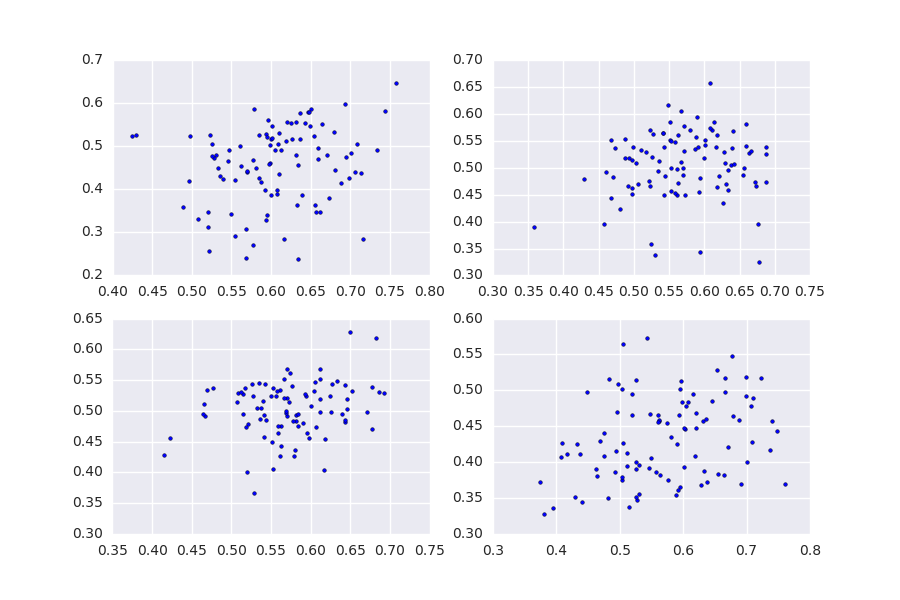

In [379]:
fig, ((ax00,ax01),(ax10,ax11)) = plt.subplots(2,2)
for i,ax in zip(range(4),[ax00,ax01,ax10,ax11]):
    grp = data#.groupby(['ti','fi','si']).mean()
    grp = grp.pipe(lambda x: x.query(f'(ti=={i})&(fi<6)'))
    ax.scatter(grp.cv, grp.ho, s=7);

In [384]:
grp = data.pipe(lambda x: x.query(f'(ti==2)&(fi<10)'))
grp.sort_values('ho')

,ti,fi,si,pi,which,cv,ho
628,2,7,6,0,0,0.640819,0.281392
627,2,7,5,0,1,0.590850,0.282496
625,2,7,4,0,1,0.475489,0.296936
622,2,7,3,0,0,0.530158,0.304037
618,2,7,1,0,0,0.560916,0.335135
631,2,7,7,0,1,0.508049,0.363765
579,2,4,2,0,1,0.527929,0.367297
619,2,7,1,0,1,0.572018,0.371176
626,2,7,5,0,0,0.530556,0.393570
553,2,2,4,0,1,0.519218,0.401114


##### get the actual guys

In [165]:
ti, fi, si, pi = 2, 5, 0, 0
rec[tags[ti]].featsdata[fi].sampsdata[si].paramsdata[pi].results

<>(holdout=(0.5397685685776971, 0.6274687290756983),
 nboost=(126, 180),
 score=0.6128754808903631,
 scores=(0.5762956858503082, 0.649455275930418),
 train=(0.9581835506304122, 0.8988213186514674))

In [399]:
def make_ikg():
    fTransNewfault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","acc","aoo","ccTEN","ooTEN","accTEN",
    "aooTEN","dayOfYear","dayOfWeek","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21",
    "oo1Drawdown10Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{10}","oo1Since62","oo1MaxSince62",
    "oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MaxSince62{10}","oo1MinSince62",
    "oo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125",
    "oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250",
    "oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{10}","aoo1Since21",
    "aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MaxSince21{10}",
    "aoo1MinSince21","aoo1MinSince21{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62",
    "aoo1Drawdown10Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1MinSince62{10}","aoo1Since125","aoo1MaxSince125",
    "aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MaxSince125{10}","aoo1MinSince125",
    "aoo1MinSince125{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250",
    "aoo1Drawdown10Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{10}","oo5","oo10","oo15","oo20",
    "oo(10-5)","oo(15-5)","oo(20-5)","oo(15-10)","oo(20-10)","oo(20-15)","aoo5","aoo10","aoo15","aoo20","aoo(10-5)",
    "aoo(15-5)","aoo(20-5)","aoo(15-10)","aoo(20-10)","aoo(20-15)","(it,af,it{1},aoo,acc){3/4}"]
    fTransNewnewfault = fTransNewfault[:-1] + ['(aoo-acc)']
    fTime = 'dayOfYear dayOfWeek'.split()
    fAsset = 'assetCodeId assetNameId'.split()
    fPriceAbsolute = 'close open'.split()
    def select_relative(f):
        return f not in set(fTime+fAsset+fPriceAbsolute)
    features = list(filter(select_relative, fTransNewnewfault)) + ['assetCodeIdWTFFlogabs', 'assetCodeIdWTFFsin2']
    train_on = [2009.,2009.75,2010.75,2011.5,2012.25,2012.5,2012.75,2013.,2013.25,2013.75,2014.,2014.25,2015.]
    cv_on = sorted(set(P.quarter.unique()) - set(train_on) - set(P[ho].quarter.unique()))
    weight = 'flat_weight'
    params = dict(early_stopping_round=50,learning_rate=.05,num_leaves=1<<12,max_depth=12,min_data_in_leaf=150,
                  min_sum_hessian_in_leaf=50,lambda_l1=.01,lambda_l2=.01)
    return make_model('flat', features, make_samples((train_on,cv_on)), params)

In [456]:
VERBOSE_EVAL = 50
#bst__ = make_ikg()
bst00 = quick(0, 0, 0, 0, 1)
bst01 = quick(0, 1, 0, 0, 0)
bst10 = quick(1, 1, 6, 0, 1)
bst20 = quick(2, 4, 3, 0, 1)
bst21 = quick(2, 2, 0, 0, 0)
bst22 = quick(2, 5, 1, 0, 0)
bst23 = quick(2, 5, 0, 0, 1)
bst24 = quick(2, 9, 2, 0, 0)

In [401]:
bsts = {-1:bst__,0:bst00,1:bst01,10:bst10,20:bst20,21:bst21,22:bst22,23:bst23,24:bst24}

In [364]:
def func(bsts, coef=None):
    if not isinstance(bsts, Iterable):
        bsts = [bsts]
    if coef is None:
        coef = [1]*len(bsts)
    def answer(F, P, ss=None):
        if ss is not None:
            F, P = F[ss], P[ss]
        trades = []
        for bst,c in zip(bsts,coef):
            guess = bst.predict(F[bst.feature_name()])*2-1
            trade = guess*P.upDown*P[bst.weight] * c / bst.std
            trades.append(trade)
        P['trade'] = sum(trades)
        daily = P[['time','trade']].groupby('time').trade.sum()
        if 'trade' in P:
            del P['trade']
        return daily#.mean()/daily.std(ddof=0)
    return answer

def score(daily):
    return daily.mean()/daily.std(ddof=0)

In [389]:
holb = {}

In [406]:
holb1 = {}
for m in [-1,0,1,10,20,21,22,23,24]:
    #model = ((0,1,20,21,22,23), (.8,.2,.0,.0,.25,.25))
    model = ((m,),(1,))
    guys = [bsts[k] for k in model[0]]
    coef = list(model[1])
    if model not in holb:
        holb1[model] = daily = func(guys, coef)(F, P, ho)
    else:
        holb1[model] = daily = holb[model]
    print(score(daily))
holb = holb1

0.6093788010903393
0.6468329132064741
0.5818983775355133
0.65750205387896
0.5285373264005305
0.5299410910460779
0.6182661211160473
0.6274687290756981
0.6285285029068451


In [407]:
corr = pd.DataFrame(holb).corr()
corr

,,"(-1,)","(0,)","(1,)","(10,)","(20,)","(21,)","(22,)","(23,)","(24,)"
,,"(1,)","(1,)","(1,)","(1,)","(1,)","(1,)","(1,)","(1,)","(1,)"
"(-1,)","(1,)",1.000000,0.862592,0.896217,0.724250,0.803409,0.805551,0.860456,0.807120,0.861205
"(0,)","(1,)",0.862592,1.000000,0.852615,0.679587,0.698200,0.747678,0.799849,0.689481,0.794055
"(1,)","(1,)",0.896217,0.852615,1.000000,0.798552,0.811293,0.856461,0.853620,0.820653,0.864593
"(10,)","(1,)",0.724250,0.679587,0.798552,1.000000,0.785622,0.803353,0.774209,0.770649,0.766516
"(20,)","(1,)",0.803409,0.698200,0.811293,0.785622,1.000000,0.838325,0.878347,0.862833,0.857689
"(21,)","(1,)",0.805551,0.747678,0.856461,0.803353,0.838325,1.000000,0.865410,0.778063,0.847431
"(22,)","(1,)",0.860456,0.799849,0.853620,0.774209,0.878347,0.865410,1.000000,0.862914,0.909081
"(23,)","(1,)",0.807120,0.689481,0.820653,0.770649,0.862833,0.778063,0.862914,1.000000,0.873314
"(24,)","(1,)",0.861205,0.794055,0.864593,0.766516,0.857689,0.847431,0.909081,0.873314,1.000000


In [333]:
def format_quarter(quarter):
    year, quart = divmod(quarter, 1)
    year, quart = int(year)-2000, 1+int(quart*4)
    return f"'{year:02}>{quart}"

comm = corr.copy()
for i,(ii,bsti) in enumerate(bsts.items()):
    for j,(jj,bstj) in enumerate(bsts.items()):
        #comm.iloc[i,j] = ', '.join(format_quarter(x) for x in sorted(bsti.tr&bstj.tr))
        comm.iloc[i,j] = len(bsti.tr&bstj.tr)
comm#.applymap(eval)

,,"(0,)","(1,)","(20,)","(21,)","(22,)","(23,)"
,,"(1,)","(1,)","(1,)","(1,)","(1,)","(1,)"
"(0,)","(1,)",13.0,5.0,7.0,8.0,6.0,6.0
"(1,)","(1,)",5.0,13.0,7.0,7.0,5.0,5.0
"(20,)","(1,)",7.0,7.0,13.0,7.0,6.0,6.0
"(21,)","(1,)",8.0,7.0,7.0,13.0,9.0,7.0
"(22,)","(1,)",6.0,5.0,6.0,9.0,13.0,5.0
"(23,)","(1,)",6.0,5.0,6.0,7.0,5.0,13.0


In [462]:
model = (( -1,  0,  1, 10, 20, 21, 22, 23, 24),
         (.0 ,  1,.0 ,.25,.0 ,.0 ,.25,.25,.25))
assert len(model[0])==len(model[1])
guys = [bsts[k] for k in model[0]]
coef = list(model[1])
if model not in holb:
    holb[model] = daily = func(guys, coef)(F, P, ho)
else:
    daily = holb[model]
print(score(daily))

0.6946369571929033


In [464]:
bst00.std, bst10.std, bst22.std, bst23.std, bst24.std

(2.57548466115442,
 0.30900869537044684,
 0.3953242075216423,
 0.5449842421121026,
 0.35897973836946206)

In [457]:
copy_production([bst00,bst10,bst22,bst23,bst24],['s00','s10','s22','s23','s24'])

    class s00(NamedO()):
        features = ["cc","oo","acc","aoo","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","oo{0/1}","oo{0/2}","oo{1}","oo{2}","(oo-aoo){0/1}","(oo-aoo){0/2}","(oo-aoo){1}","(oo-aoo){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd","vp1dd{1}","vp1dd{2}","oo1Drawdown10Since62","oo1Drawdown20Since62","oo1MaxSince62{10}","oo1MaxSince62{20}","oo1MinSince62","oo1Drawup1Since62","oo1MinSince62{5}","volatility20MaxSince62","volatility20MaxSince62{5}","volatility20Drawup(10-5)Since62","volatility20Drawup(20-10)Since62","volatility20MinSince62{20}","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{10}","oo1MaxSince250{20}","oo1MinSince250","oo1Drawup1Since250","oo1MinSince250{5}","volatility20MaxSince250","volatility20MaxSince250{5}","volatility20Drawup(10-5)Since250",

old

In [279]:
/print rec[tags[3]].featsdata[0].feats.replace('\n\n','\n')

    <>~Market & (
        | ( 
            <>Return{(aoo[1:])} 
            & (
                | Drawdown[1:, 5:,10:, 10:5,20:10] 
                | Since{Max&index[20]} 
                | Since{Min&index[0,20]} 
              )
            & Since[21:, 62:, 250:] 
          )
        | ( 
            <>Return{dd} & VP[ 10:] 
            & (
                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max} 
                | Since{Max & index[0,20]} 
                | Drawup[1,20:] 
                | Since{Min & index[0,20]} 
              )
            & Since[21:, 62:, 250:] 
          )
      )
    | 
        <>Return{pure&~dd} & VP[60:] 



0 12 (3, 0, 0, 0)
0.41737434493687536


<IPython.core.display.Javascript object>


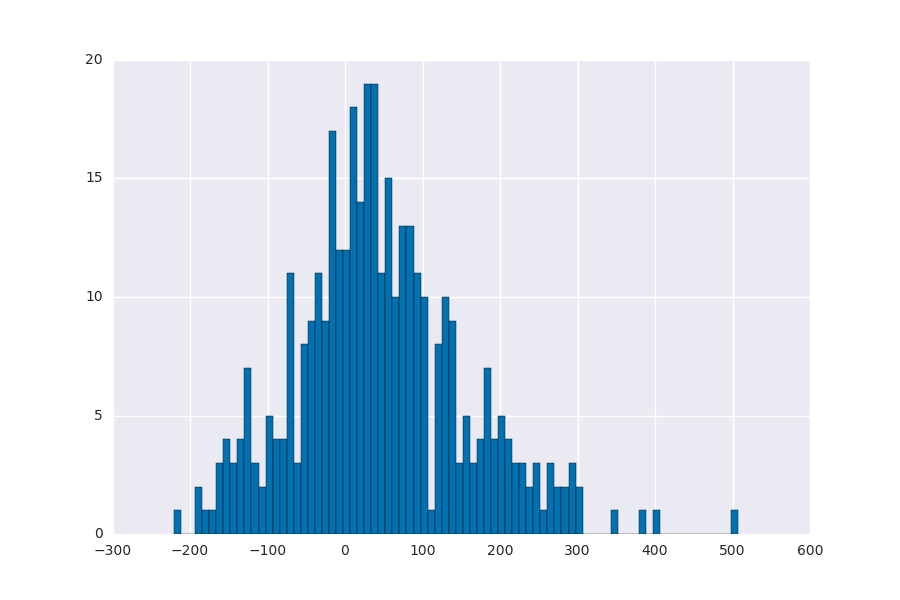

In [281]:
ii = [
    (0,0,0,0),
    (0,0,1,0),
    (0,1,0,0),
    (0,1,1,0),
    (1,0,0,0),
    (1,0,1,0),
    (1,1,0,0),
    (1,1,1,0),
    (2,0,0,0),
    (2,0,1,0),
    (2,1,0,0),
    (2,1,1,0),
    (3,0,0,0),
    (3,0,1,0),
    (3,1,0,0),
    (3,1,1,0),
]
j = [12]
guess = []
for k, i in enumerate(j):
    print(k, i, ii[i])
    for sign in [1, -1]:
        ii[i] = ii[i][:2] + (ii[i][2]+sign*0.5,) + ii[i][3:]
        P['guess'] = bsts[ii[i]].predict(F[make_features(rec[tags[ii[i][0]]].featsdata[ii[i][1]].feats)])*2-1
        P.guess = P.guess*(np.abs(P.guess)>=0.0)

        P['trade'] = P.guess*P.upDown*P[tags[ii[i][0]]+'_weight']
        std = P.trade.std(ddof=0)
        P.trade /= std
        guess.append(P.trade)

P.trade = sum(guess)
daily = P[ho].groupby('time').trade.sum()

print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);